---

# DOMAĆI ZADATAK:

## Konstantin Malešević, RA166/2022.
### U prilogu je iskorišćen kod sa repozitorijuma:
 https://github.com/rapaja/rl_playground/blob/main/notebooks/SLAA/MultiarmBandit.ipynb
 zarad najlakšeg načina sporazumevanja. **Rešenje** se nalazi ispod sekcije *Assignments for Individual Work*.

**Napomena :** *Zbog stohastičke osobine bandita koja je implementirana u samom kreiranju objekta (pri svakom novom pokretanju koda koji sadrži kreiranje objekta tipa Bandit, generišu se nove srednje vrednosti i devijacije koje se pripisuju banditima) nije preporučljivo ponovo pokretati sve ćelije notebook-a jer se mogu dobiti drugačije vrednosti za koje ne važe priloženi komentari i grafici, preporuka je analizirati trenutno vidljive grafike i u slučaju testiranja, kreirati novu ćeliju za željeni test slučaj.*

---

# Multiarm Bandit

**ONE ARMED BANDIT** is a slang for a _slot machine_: It has one arm (one leaver) and it will rob you. Imagine, however, that there is not one but many such bandits. Some are worse than others, and some may even reward you. The problem, however, is that they all look the same, and we do not know how bad each one of the is. Since there are many, each with only one hand, the multitude of slot machines is referred to as **MULTIARM BANDIT**. 

<div class="alert alert-block alert-info">
<b>The Goal:</b> 
Devise a strategy for investigating the bandits (pulling the leavers and obtaining the reward/payinh the penalty) so that the total gain is maximized (total loss is minimized).
</div>

## Basic Imports

In [12]:
from typing import Iterable
import random

import numpy as np
import matplotlib.pyplot as plt

from tqdm import trange


## The Environment — Process Model

### Simulating one Bandit

In [15]:
class Bandit:
    """A bandit with uniform reward distribution."""

    def __init__(self, mean: float, span: float):
        """Initialize the bandit.

        Regardless of the received action, the bandit will return reward
        uniformly sampled from segment [`mean`-`span`, `mean`+`span`].

        Args:
            mean (float): Mean (expected) value of the reward.
            span (float): Span of the reward.
        """
        self.mean = mean
        self.span = span

    def pull_leaver(self) -> float:
        """Pull leaver and obtain reward.

        Returns:
            float: The obtained reward.
        """
        return self.mean + 2*self.span * (random.random()-0.5) # random number in [mean-span, mean+span]       

### Testing one Bandit

We should always test a piece of code :) This is not a formal test, but it is still a test.

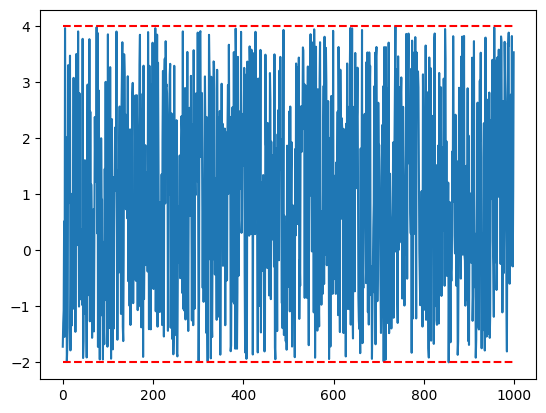

In [3]:
test_mean = 1.0
test_span = 3.0
test_len = 1000

test_bandit = Bandit(test_mean, test_span)
test_rewards = [test_bandit.pull_leaver() for _ in range(test_len)]

plt.plot(test_rewards, label="rewards")
plt.plot((test_mean+test_span)*np.ones(test_len), linestyle="--", color="r")
plt.plot((test_mean-test_span)*np.ones(test_len), linestyle="--", color="r")

### Building an Environment of Bandits

Now, we define an environment consisting of several bandits.

In [16]:
class BanditsEnvironment:
    """An environment consisting of multiple bandits."""

    def __init__(self, bandits: Iterable[Bandit], penalty=1000):
        """Initialize the environment.

        Args:
            bandits (iter[Bandit]): Bandits to be used within the environment.
            penalty (int, optional): 
                If the external agents attempts to use a bandit not in the list,
                i.e. if the chosen action is negative or bigger than the index of
                the last bandit, the returned reward will be `-penalty`. Defaults to 1000.
        """
        self.bandits: list[Bandit] = list(bandits)
        self.penalty = penalty

    def take_action(self, a: int):
        """
        Select bandit `a` and pull its leaver. 
        
        If the selected agent is valid, return the obtained reward.
        Otherwise, return negative penalty.
        """
        if a<0 or a>=len(self.bandits):
            return -self.penalty
        else:
            return self.bandits[a].pull_leaver()

<div class="alert alert-block alert-info">
<b>Tip:</b> 
The `Sequence` and `Iterable` **abstract base classes** (can also be used as **type annotations**) usually adhere to the following conventions:

* `Iterable` is any object that defines `__iter__` or `__getitem__`.
* `Sequence` is any object that defines `__getitem__` and `__len__`. By definition, any sequence is an iterable. 

The `Sequence` class also defines other methods such as `__contains__`, `__reversed__` that calls the two required methods.

`list`, `tuple`, `str` are the most common sequences. Some built-in iterables are not sequences.
</div>

For more tips and tricks regarding notebook markdown, please see [here](https://towardsdatascience.com/modernize-your-sinful-python-code-with-beautiful-type-hints-4e72e98f6bf1).


### Testing the Environment

Let us now test the environment. We will build it so that the mean value of the reward returned by each bandit is equal to the square of its index. The span will be equal to the index.

In [17]:
test_env_size = 5
test_bandits = [Bandit(i**2, i) for i in range(test_env_size)]
test_env = BanditsEnvironment(test_bandits)

We will first test whether one of the bandits behaves as expected...

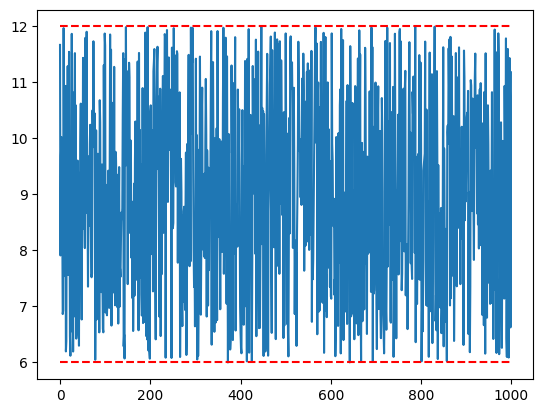

In [6]:
selected_bandit = 3
test_rewards = [test_env.take_action(selected_bandit) for _ in range(test_len)]

plt.plot(test_rewards, label="rewards")
plt.plot((selected_bandit**2+selected_bandit)*np.ones(test_len), linestyle="--", color="r")
plt.plot((selected_bandit**2-selected_bandit)*np.ones(test_len), linestyle="--", color="r")

Then, we will test if the environment behaves correctly when an invalid action is given...

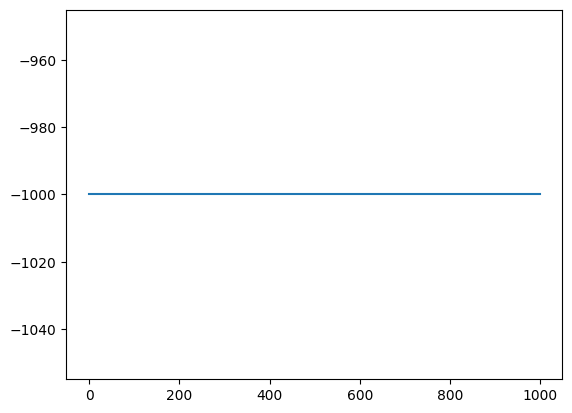

In [7]:
selected_bandit = -1
test_rewards = [test_env.take_action(selected_bandit) for _ in range(test_len)]

plt.plot(test_rewards, label="rewards")

Finally, let us check if the code runs with arbitrarily selected actions. This is quite tricky to do, since the whole system behaves stochastically. However, we know that the bandits are independent, and also that their mean values are 0, 1, 4, 9, and 16. Assuming each bandit is activated with the same probability, the mean value rewards obtained after many actions should be (0 + 1 + 4 + 9 + 16)/5 = 6.

In [10]:
test_rewards = [test_env.take_action(random.randint(0, 4)) for _ in range(test_len)]
test_mean = sum(test_rewards)/test_len

print("TEST MEAN = ", test_mean)

TEST MEAN =  5.967375529261734


## Decision Policies

In [5]:
def choose_greedy_action(q):
    return np.argmax(q)

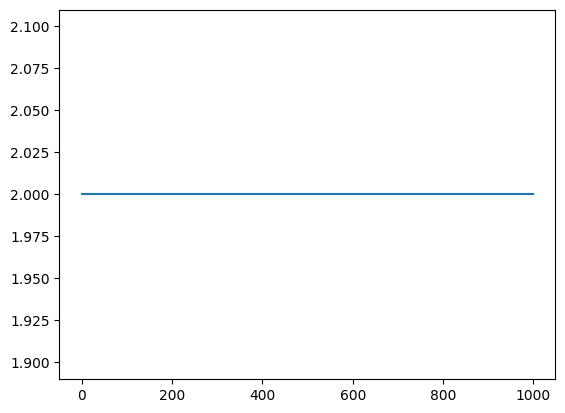

In [12]:
test_q = [1, 2, 3, 2, 1]

test_actions = [choose_greedy_action(test_q) for _ in range(test_len)]

plt.plot(test_actions)

In [6]:
def choose_random_action(n):
    return random.randint(0, n-1)

In [7]:
def choose_eps_greedy_action(q, eps):
    if random.random() > eps:
        return choose_greedy_action(q)
    else:
        return choose_random_action(len(q))

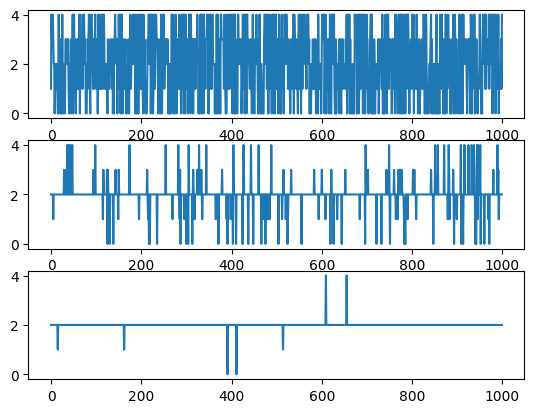

In [15]:
plt.subplot(3, 1, 1)
plt.plot([choose_eps_greedy_action(test_q, 1.0) for _ in range(test_len)])
plt.subplot(3, 1, 2)
plt.plot([choose_eps_greedy_action(test_q, 0.2) for _ in range(test_len)])
plt.subplot(3, 1, 3)
plt.plot([choose_eps_greedy_action(test_q, 0.01) for _ in range(test_len)])

## Training Loop

In [18]:
BANDITS_NO = 5
ATTEMPTS_NO = 5000
ALPHA = 0.1
EPSILON = 0.1

bandits = [Bandit(10*(random.random()-0.5), 5*random.random()) for _ in range(BANDITS_NO)]
env = BanditsEnvironment(bandits)

q = [100 for _ in range(BANDITS_NO)]
rewards = []
for t in trange(ATTEMPTS_NO):
    a = choose_eps_greedy_action(q, EPSILON)
    r = env.take_action(a)
    q[a] = q[a] + ALPHA * (r - q[a])
    
    # just for logging
    rewards.append(r)

100%|██████████| 5000/5000 [00:00<00:00, 348433.57it/s]


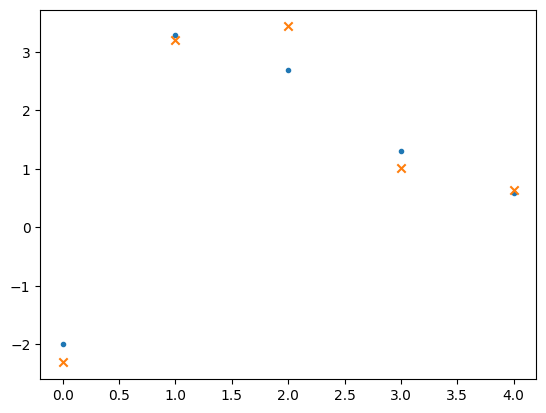

In [41]:
plt.scatter(range(len(q)), q, marker=".")
plt.scatter(range(len(q)), [b.mean for b in env.bandits], marker="x")

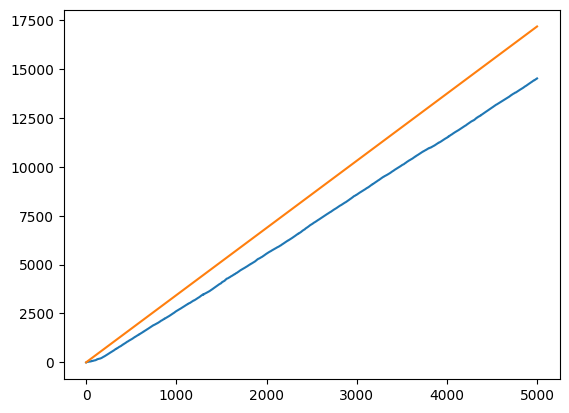

In [42]:
g = np.cumsum(rewards)
max_r = max([b.mean for b in env.bandits])
plt.plot(g)
plt.plot(np.cumsum(max_r * np.ones(len(g))))

## Assignments for Individual Work

1. Experiment with the value of `epsilon`. Try smaller values, and verify that the slope difference is smaller. Verify also the oposite fact: increasing `epsilon` decreases the slope of the plotted achieved gain. Explain.
   
1. Perform a training run to learn the `q` vector (in essence, to estimate the mean value of the reward returned by each bandit). Create a test loop, in which the learned `q` values remain fixed. Compare performance of the agent to the ideal performance (as it is done in the previous point).

1. Plot the change of the estimated `q` values in time. Show that with passing time the algorithm sucessfully approximates mean rewards of all bandits.

1. Modify the environment so that the mean values of all bandits change in time. Repeat the training procedure. Evaluate its effectiveness.

---

# REŠENJE:

## 1) Analiza za razlicite vrednosti `epsilon`-a

### Training loop

In [43]:
# Svi ostali parametri ostaju isti, samo menjamo vrednost epsilon-a.
EPSILON = 1 # Promena vrednosti sa 0.1 na 1

q = [100 for _ in range(BANDITS_NO)]
rewards = []
for t in trange(ATTEMPTS_NO):
    a = choose_eps_greedy_action(q, EPSILON)
    r = env.take_action(a)
    q[a] = q[a] + ALPHA * (r - q[a])

    # just for logging
    rewards.append(r)

100%|██████████| 5000/5000 [00:00<00:00, 1014881.92it/s]


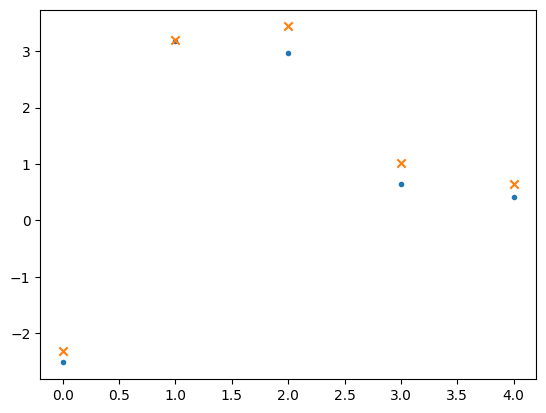

In [44]:
plt.scatter(range(len(q)), q, marker=".")
plt.scatter(range(len(q)), [b.mean for b in env.bandits], marker="x")

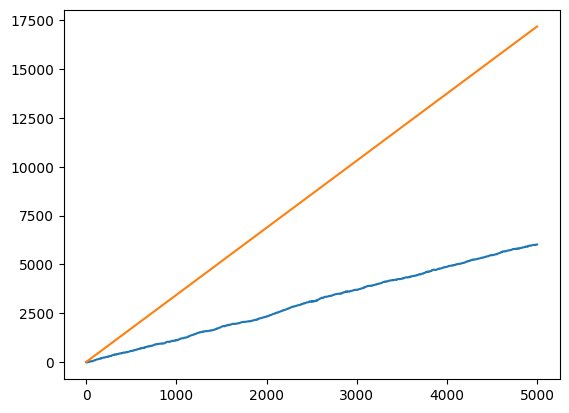

In [45]:
g = np.cumsum(rewards)
max_r = max([b.mean for b in env.bandits])
plt.plot(g)
plt.plot(np.cumsum(max_r * np.ones(len(g))))

**Komentar** : *Vidimo da naša kumulativna suma nagrada sada mnogo više odstupa od idealne vrednosti tj. od slučaja da smo pri delimično nasumičnoj politici birali češće bandita sa najvećom srednjom vrednošću. Odavde zaključujemo da je potrebno smanjivati epsilon, pa je s toga sledeća vrednost sa kojom pokušavamo 0.5.*

In [46]:
# Svi ostali parametri ostaju isti, samo menjamo vrednost epsilon-a.
EPSILON = 0.5 # Promena vrednosti sa 1 na 0.5

q = [100 for _ in range(BANDITS_NO)]
rewards = []
for t in trange(ATTEMPTS_NO):
    a = choose_eps_greedy_action(q, EPSILON)
    r = env.take_action(a)
    q[a] = q[a] + ALPHA * (r - q[a])

    # just for logging
    rewards.append(r)

100%|██████████| 5000/5000 [00:00<00:00, 329575.06it/s]


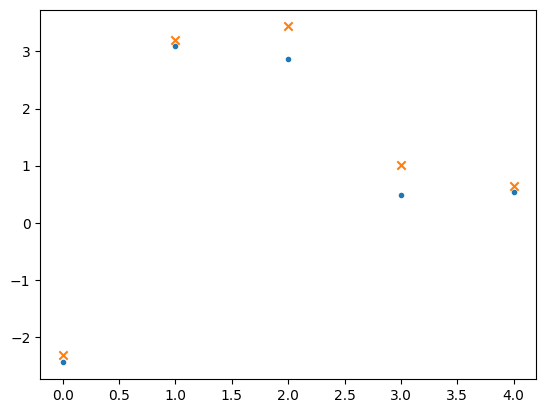

In [47]:
plt.scatter(range(len(q)), q, marker=".")
plt.scatter(range(len(q)), [b.mean for b in env.bandits], marker="x")

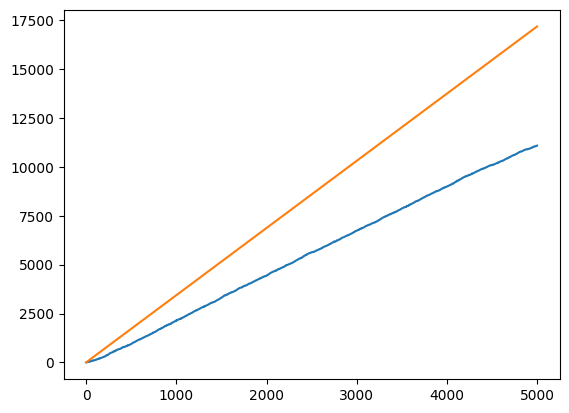

In [48]:
g = np.cumsum(rewards)
max_r = max([b.mean for b in env.bandits])
plt.plot(g)
plt.plot(np.cumsum(max_r * np.ones(len(g))))

**Komentar :** *Na osnovu dobijenog rezultata, možemo primetiti da sada suma nagrada bolje konvergira ka najboljoj za razliku od u prethodnog slučaja tako da nastavljamo sa smanjivanjem vrednosti `epsilon`-a i pratimo dalje rezultate. Takođe, već možemo da zaključimo da sa opadanjem vrednosti `epsilon`-a opada i vrednost nagiba izmedju idealne i ostvarene vrednosti. S toga `epsilon` vrednost sa 0.5 smanjujemo na 0.005.*

In [49]:
# Svi ostali parametri ostaju isti, samo menjamo vrednost epsilon-a.
EPSILON = 0.005 # Promena vrednosti sa 0.5 na 0.005

q = [100 for _ in range(BANDITS_NO)]
rewards = []
for t in trange(ATTEMPTS_NO):
    a = choose_eps_greedy_action(q, EPSILON)
    r = env.take_action(a)
    q[a] = q[a] + ALPHA * (r - q[a])

    # just for logging
    rewards.append(r)

100%|██████████| 5000/5000 [00:00<00:00, 312122.64it/s]


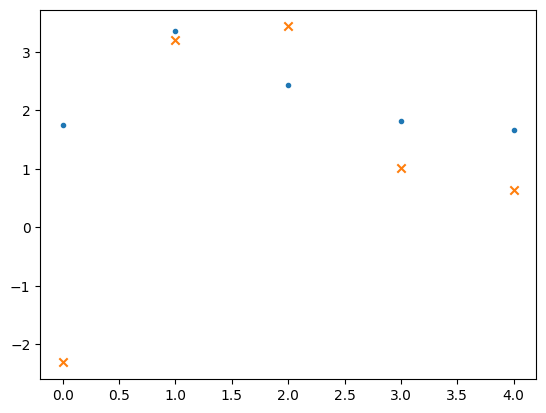

In [50]:
plt.scatter(range(len(q)), q, marker=".")
plt.scatter(range(len(q)), [b.mean for b in env.bandits], marker="x")

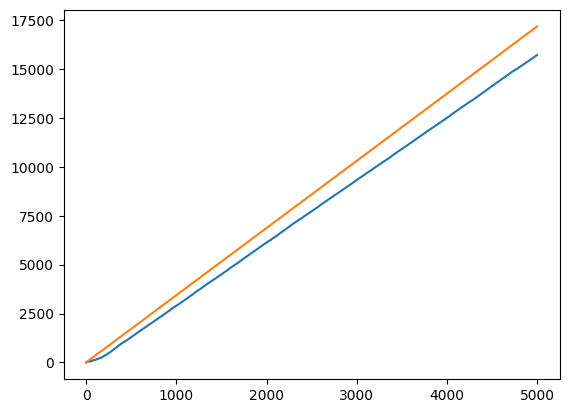

In [51]:
g = np.cumsum(rewards)
max_r = max([b.mean for b in env.bandits])
plt.plot(g)
plt.plot(np.cumsum(max_r * np.ones(len(g))))

**Komentar :** *Kao i u prethodnim koracima nastavljamo sa istim načinom razmišljanja i smanjujemo vrednost epsilona sa 0.005 na 0.00005.*

In [52]:
# Svi ostali parametri ostaju isti, samo menjamo vrednost epsilon-a.
EPSILON = 0.00005 # Promena vrednosti sa 0.005 na 0.00005

q = [100 for _ in range(BANDITS_NO)]
rewards = []
for t in trange(ATTEMPTS_NO):
    a = choose_eps_greedy_action(q, EPSILON)
    r = env.take_action(a)
    q[a] = q[a] + ALPHA * (r - q[a])

    # just for logging
    rewards.append(r)

100%|██████████| 5000/5000 [00:00<00:00, 301661.68it/s]


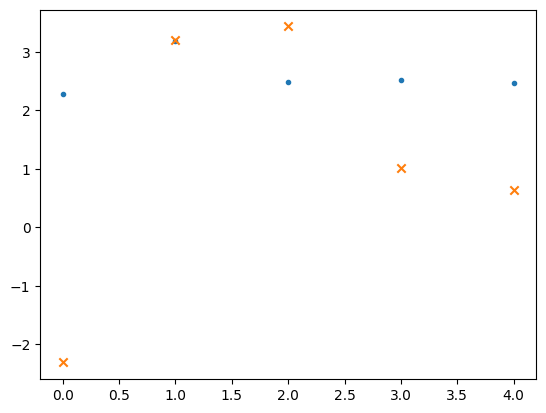

In [53]:
plt.scatter(range(len(q)), q, marker=".")
plt.scatter(range(len(q)), [b.mean for b in env.bandits], marker="x")

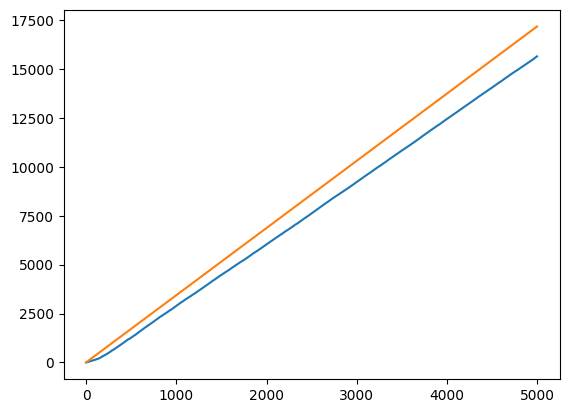

In [54]:
g = np.cumsum(rewards)
max_r = max([b.mean for b in env.bandits])
plt.plot(g)
plt.plot(np.cumsum(max_r * np.ones(len(g))))

**Komentar :** *Iz navedenog eksperimenta možemo da zaključimo da je promena vrednosti `epsilon`-a direktno proporcionalna promeni nagiba izmedju idealne i realne (ostvarene) sume nagrada odnosno inverzno proporcionala realnoj (ostvarenoj) sumi nagrada. Odatle zaključujemo da bi pri datim parametrima, samo promenom vrednosti `epsilon`-a, najbolje rešenje dobili ukoliko bi totalno izbacili stohastiku iz naše trenutne politike biranja akcije, odnosno ukoliko bi vrednost epsilona postavili na 0.*

In [85]:
# Svi ostali parametri ostaju isti, samo menjamo vrednost epsilon-a.
EPSILON = 0 # Promena vrednosti sa 0.00005 na 0

q = [100 for _ in range(BANDITS_NO)]
rewards = []
for t in trange(ATTEMPTS_NO):
    a = choose_eps_greedy_action(q, EPSILON)
    r = env.take_action(a)
    q[a] = q[a] + ALPHA * (r - q[a])

    # just for logging
    rewards.append(r)

100%|██████████| 5000/5000 [00:00<00:00, 294916.61it/s]


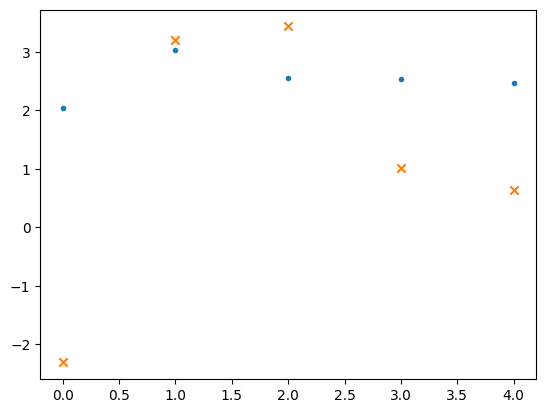

In [56]:
plt.scatter(range(len(q)), q, marker=".")
plt.scatter(range(len(q)), [b.mean for b in env.bandits], marker="x")

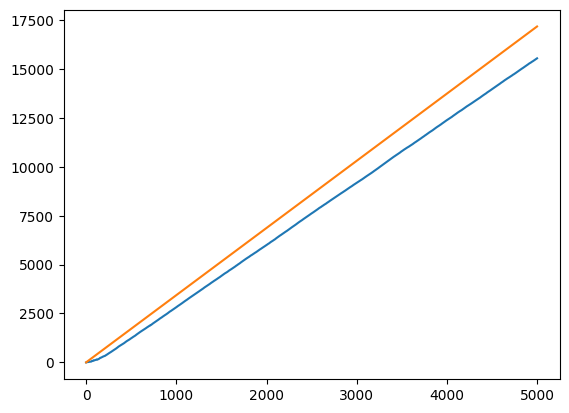

In [57]:
g = np.cumsum(rewards)
max_r = max([b.mean for b in env.bandits])
plt.plot(g)
plt.plot(np.cumsum(max_r * np.ones(len(g))))

**Komentar :** *Kao što možemo da vidimo, vrednosti `epsilon`-a u 0 sa devijacijom $10^{-3}$ daje približno identične rezultate.*

---

## 2) Korišćenje naučenog q, izbacivanje nasumične politike (istraživanja) i primenjivanje samo pohlepne, poređenje za epsilon = 0.1 i epsilon = 0

### Test loop

In [58]:
EPSILON = 0.1 # Ostavljamo inicijalnu vrednost epsilon-a.

# Ovde je izbačeno q zbog osobine notebook-a da pamti zadnju upisanu vrednost u jupyter varijablama, s toga posle izvršavanja prethodne petlje, q vrednost je već donekle naučena.

rewards = []
for t in trange(ATTEMPTS_NO):
    a = choose_eps_greedy_action(q, EPSILON)
    r = env.take_action(a)
    q[a] = q[a] + ALPHA * (r - q[a])

    # just for logging
    rewards.append(r)

100%|██████████| 5000/5000 [00:00<00:00, 341566.83it/s]


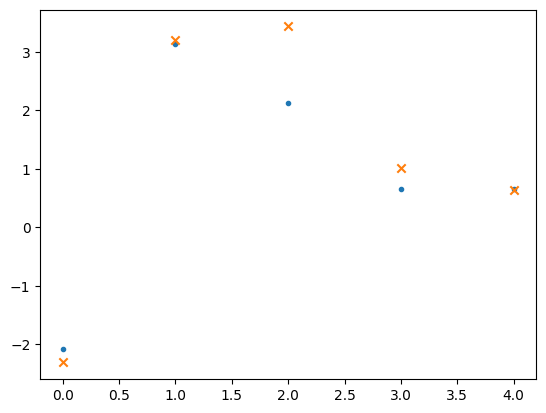

In [59]:
plt.scatter(range(len(q)), q, marker=".")
plt.scatter(range(len(q)), [b.mean for b in env.bandits], marker="x")

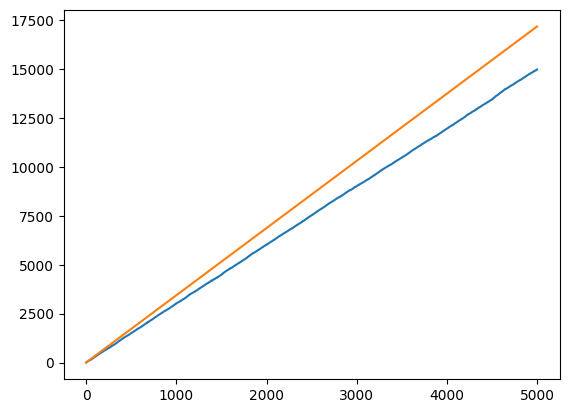

In [60]:
g = np.cumsum(rewards)
max_r = max([b.mean for b in env.bandits])
plt.plot(g)
plt.plot(np.cumsum(max_r * np.ones(len(g))))

**Komentar :** *Kao što možemo da vidimo nelinearnost u početnim iteracijama kod ostvarene vrednosti je skoro u potpunosti isčezla. To bi značilo da sada možemo dobiti dosta bolje poklapanje i u velikoj meri eliminisati faktor žaljenja.*

In [86]:
EPSILON = 0 # Promena sa inicijalne vrednosti 0.1 na 0.

#Neposredno pre izvršavanja ove sekcije potrebno je izvršiti poslednju training sekciju iz dela zadatka pod 1) kako bi rezultati bili relevantni za upoređivanje sa ovim iznad.

rewards = []
for t in trange(ATTEMPTS_NO):
    a = choose_eps_greedy_action(q, EPSILON)
    r = env.take_action(a)
    q[a] = q[a] + ALPHA * (r - q[a])

    # just for logging
    rewards.append(r)

100%|██████████| 5000/5000 [00:00<00:00, 195790.57it/s]


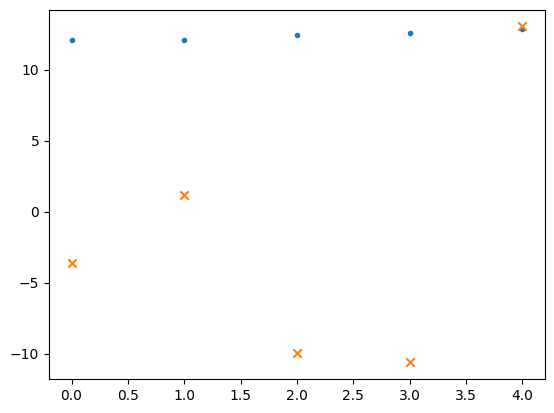

In [87]:
plt.scatter(range(len(q)), q, marker=".")
plt.scatter(range(len(q)), [b.mean for b in env.bandits], marker="x")

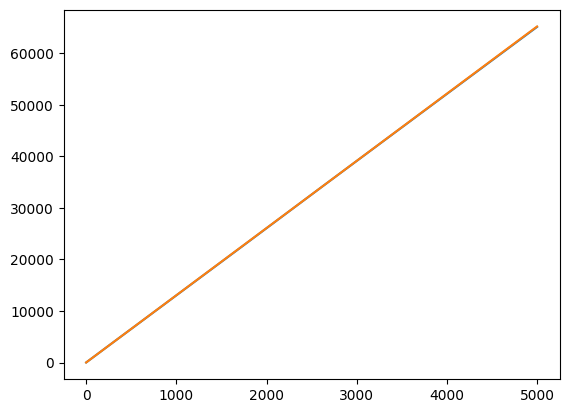

In [88]:
g = np.cumsum(rewards)
max_r = max([b.mean for b in env.bandits])
plt.plot(g)
plt.plot(np.cumsum(max_r * np.ones(len(g))))

**Komentar :** *Uočavamo idealno poklapanje između idealne i ostvarene vrednosti i zaključujemo da sa inicijalno **naučenim** `q` (pogođenim ili naučenim), koristeći pohlepnu politiku biranja (`epsilon = 0`) totalno izbacujemo nelinearnost i samim tim ostvarena vrednost za ovaj slučaj značajno bolje konvergira.*

---

## 3) Iscrtavanje promene vrednosti `q`-a kod svih bandita tokom vremena.

In [69]:
EPSILON = 0
rewards = []
# Naučeno q
q_history = []
for t in trange(ATTEMPTS_NO):
    a = choose_eps_greedy_action(q, EPSILON)
    r = env.take_action(a)
    q[a] = q[a] + ALPHA * (r - q[a])

    # just for logging
    rewards.append(r)
    # Pamtimo sve vrednosti q-a
    q_history.append(q.copy())

100%|██████████| 5000/5000 [00:00<00:00, 183933.27it/s]


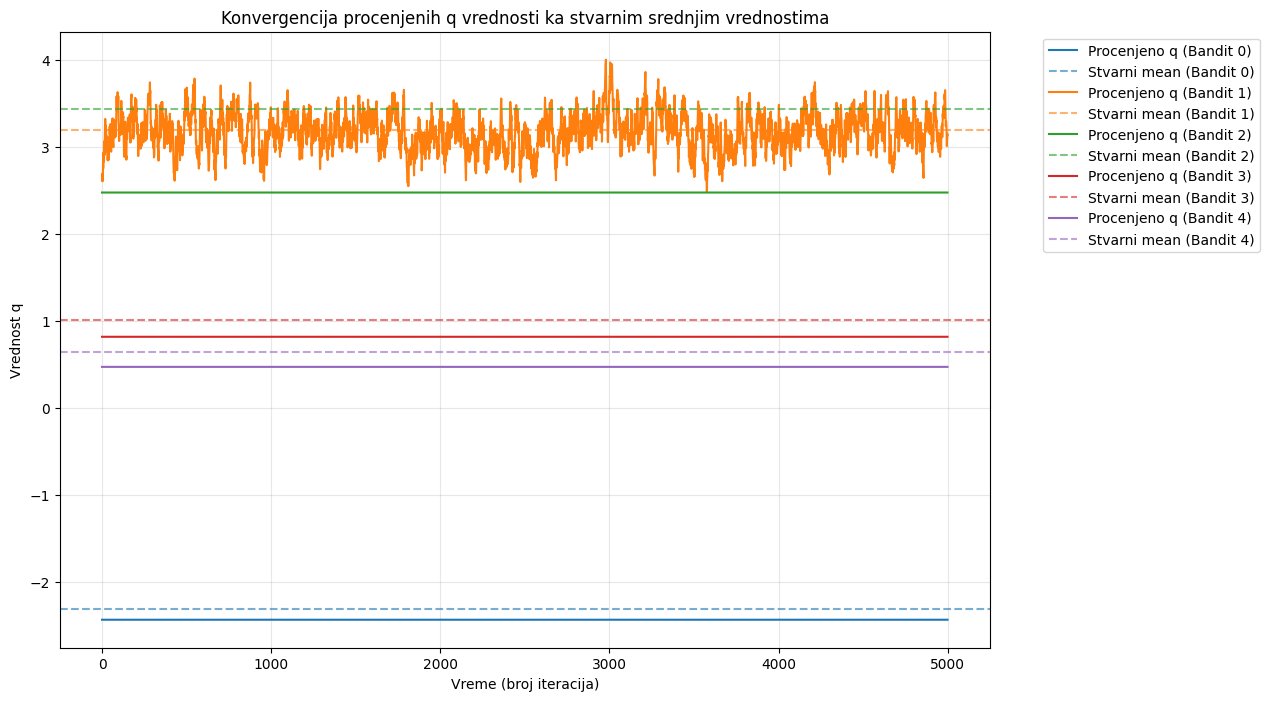

In [70]:
# Pretvaramo listu u numpy niz radi lakšeg crtanja (dimenzije: Broj_pokušaja x Broj_bandita)
q_history = np.array(q_history)

plt.figure(figsize=(12, 8))

# Prolazimo kroz svakog bandita da nacrtamo njegovu liniju
for i in range(len(env.bandits)):
    # Iscrtavamo kako je algoritam procenjivao vrednost i-tog bandita kroz vreme
    plt.plot(q_history[:, i], label=f'Procenjeno q (Bandit {i})')

    # Iscrtavamo stvarnu srednju vrednost (cilj kojem težimo) kao isprekidanu liniju
    # Ovo zadovoljava deo zadatka: "pokaži da aproksimira srednje nagrade"
    plt.axhline(y=env.bandits[i].mean, color=plt.gca().lines[-1].get_color(), linestyle='--', alpha=0.6, label=f'Stvarni mean (Bandit {i})')

plt.xlabel('Vreme (broj iteracija)')
plt.ylabel('Vrednost q')
plt.title('Konvergencija procenjenih q vrednosti ka stvarnim srednjim vrednostima')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Legenda sa strane da ne smeta
plt.grid(True, alpha=0.3)
plt.show()

**Komentar :** *Kao što možemo videti, zahvaljujući pohlepnoj politici, koristeći već naučeno `q`, biran je bandit sa najvećom sumom koji najbolje konvergira u srednju vrednost.*

In [71]:
EPSILON = 0.1
rewards = []
# Naučeno q
q_history = []
for t in trange(ATTEMPTS_NO):
    a = choose_eps_greedy_action(q, EPSILON)
    r = env.take_action(a)
    q[a] = q[a] + ALPHA * (r - q[a])

    # just for logging
    rewards.append(r)
    # Pamtimo sve vrednosti q-a
    q_history.append(q.copy())

100%|██████████| 5000/5000 [00:00<00:00, 262275.14it/s]


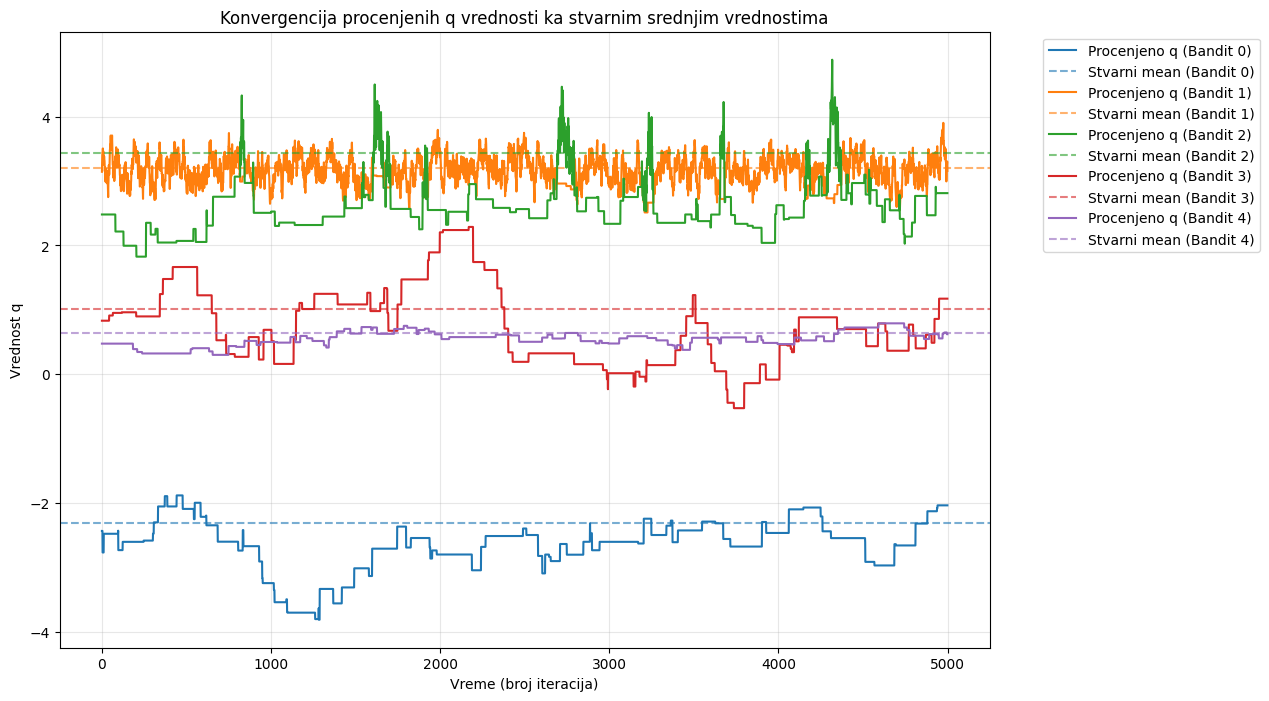

In [72]:
# Pretvaramo listu u numpy niz radi lakšeg crtanja (dimenzije: Broj_pokušaja x Broj_bandita)
q_history = np.array(q_history)

plt.figure(figsize=(12, 8))

# Prolazimo kroz svakog bandita da nacrtamo njegovu liniju
for i in range(len(env.bandits)):
    # Iscrtavamo kako je algoritam procenjivao vrednost i-tog bandita kroz vreme
    plt.plot(q_history[:, i], label=f'Procenjeno q (Bandit {i})')

    # Iscrtavamo stvarnu srednju vrednost (cilj kojem težimo) kao isprekidanu liniju
    # Ovo zadovoljava deo zadatka: "pokaži da aproksimira srednje nagrade"
    plt.axhline(y=env.bandits[i].mean, color=plt.gca().lines[-1].get_color(), linestyle='--', alpha=0.6, label=f'Stvarni mean (Bandit {i})')

plt.xlabel('Vreme (broj iteracija)')
plt.ylabel('Vrednost q')
plt.title('Konvergencija procenjenih q vrednosti ka stvarnim srednjim vrednostima')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Legenda sa strane da ne smeta
plt.grid(True, alpha=0.3)
plt.show()

**Komentar :** *Vraćanjem u razmatranje nasumične politike (istraživanja), vidimo da i drugi banditi bivaju birani stohastički u 10% slučajeva (`epsilon = 0.1`)  i shodno tome možemo videti njihovu konvergenciju u srednje vrednosti. Takođe, kao i u prošlom slučaju, lako je zaključiti da je najbolji bandit (akcija) koji najbolje konvergira u svoju srednju vrednost koja je najveća u poredjenju sa ostalim **Bandit 1**.*

## 4) Modifikovanje okoline tako da se banditi menjaju tokom vremena

In [73]:
EPSILON = 0.1
q = [0 for _ in range(BANDITS_NO)] # Ponovo inicijalizacija
rewards = []

# Za potrebe crtanja i evaluacije moramo da pamtimo istoriju
q_history = []
true_means_history = []

# Parametar koliko se brzo menjaju banditi (standardna devijacija promene)
CHANGE_STD = 0.1

for t in trange(ATTEMPTS_NO):
    a = choose_eps_greedy_action(q, EPSILON)
    r = env.take_action(a)
    q[a] = q[a] + ALPHA * (r - q[a])

    # just for logging
    rewards.append(r)

    # Svakom banditu malo promenimo srednju vrednost (Random Walk)
    for b in env.bandits:
        b.mean += np.random.normal(0, CHANGE_STD)

    # Logovanje za grafik
    q_history.append(q.copy())
    # Pamtimo trenutne prave srednje vrednosti da vidimo da li ih stižemo
    true_means_history.append([b.mean for b in env.bandits])

100%|██████████| 5000/5000 [00:00<00:00, 36129.82it/s]


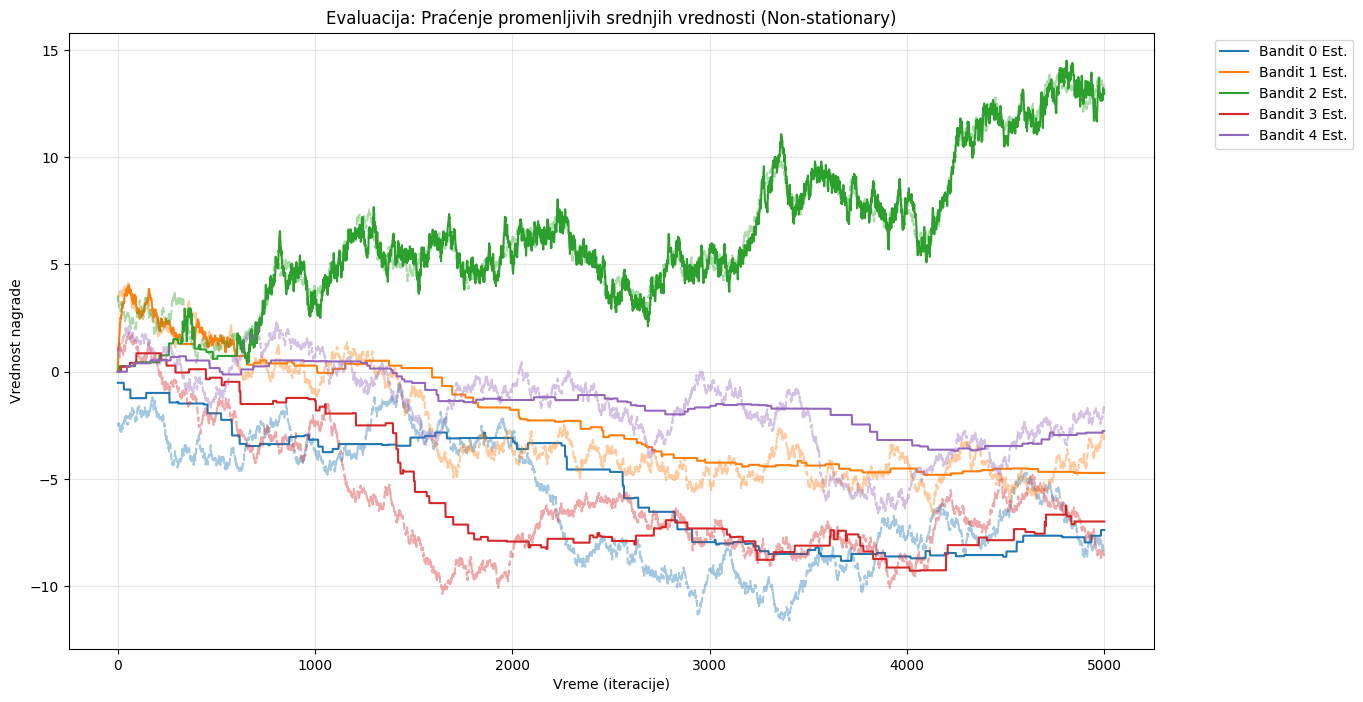

In [74]:
q_history = np.array(q_history)
true_means_history = np.array(true_means_history)

plt.figure(figsize=(14, 8))

# Crtamo samo za prvih nekoliko bandita da ne bude haos na grafiku (npr. 3)
# ili za sve ako ih je malo (ovde ih je 5, pa može sve)
for i in range(BANDITS_NO):
    color = plt.cm.tab10(i) # Dodeljujemo istu boju za par (procena, istina)

    # Puna linija = Procena (Q vrednost)
    plt.plot(q_history[:, i], color=color, label=f'Bandit {i} Est.')

    # Isprekidana linija = Stvarna vrednost (koja se sada menja)
    plt.plot(true_means_history[:, i], color=color, linestyle='--', alpha=0.4)

plt.title("Evaluacija: Praćenje promenljivih srednjih vrednosti (Non-stationary)")
plt.xlabel("Vreme (iteracije)")
plt.ylabel("Vrednost nagrade")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

**Komentar :** *Vidimo da **Bandit 1** u početku najbolje konvergira i skoro idealno prati promene srednje vrednosti tokom vremena, gde kasnije njegovo mesto zamenjuje **Bandit 2**, pri čemu je početna pogođena (zadata) suma `q = 0`.*

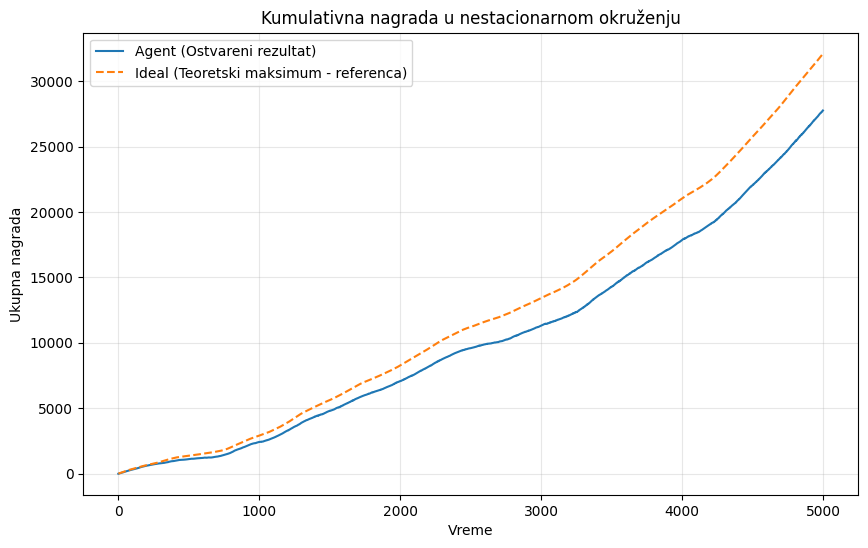

Ukupan Regret na kraju: 4341.50


In [75]:
# 1. Računamo šta je bio maksimum u svakom trenutku T
# true_means_history je matrica [vreme, banditi]
# axis=1 znači da za svaki vremenski korak tražimo najveću srednju vrednost među banditima
optimal_rewards_per_step = np.max(true_means_history, axis=1)

# 2. Pravimo kumulativnu sumu tih idealnih nagrada
ideal_cumulative = np.cumsum(optimal_rewards_per_step)

# 3. Stvarni rezultat
g = np.cumsum(rewards)

# 4. Crtanje
plt.figure(figsize=(10, 6))
plt.plot(g, label='Agent (Ostvareni rezultat)')
plt.plot(ideal_cumulative, label='Ideal (Teoretski maksimum - referenca)', linestyle='--')

plt.title('Kumulativna nagrada u nestacionarnom okruženju')
plt.xlabel('Vreme')
plt.ylabel('Ukupna nagrada')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Dodatno: Izračunavanje 'Regret-a' (koliko smo izgubili u odnosu na ideal)
regret = ideal_cumulative - g
print(f"Ukupan Regret na kraju: {regret[-1]:.2f}")

In [76]:
EPSILON = 0
q = [50 for _ in range(BANDITS_NO)] # Ponovo inicijalizacija
rewards = []

# Za potrebe crtanja i evaluacije moramo da pamtimo istoriju
q_history = []
true_means_history = []

# Parametar koliko se brzo menjaju banditi (standardna devijacija promene)
CHANGE_STD = 0.1

for t in trange(ATTEMPTS_NO):
    a = choose_eps_greedy_action(q, EPSILON)
    r = env.take_action(a)
    q[a] = q[a] + ALPHA * (r - q[a])

    # just for logging
    rewards.append(r)

    # Svakom banditu malo promenimo srednju vrednost (Random Walk)
    for b in env.bandits:
        b.mean += np.random.normal(0, CHANGE_STD)

    # Logovanje za grafik
    q_history.append(q.copy())
    # Pamtimo trenutne prave srednje vrednosti da vidimo da li ih stižemo
    true_means_history.append([b.mean for b in env.bandits])

100%|██████████| 5000/5000 [00:00<00:00, 117962.66it/s]


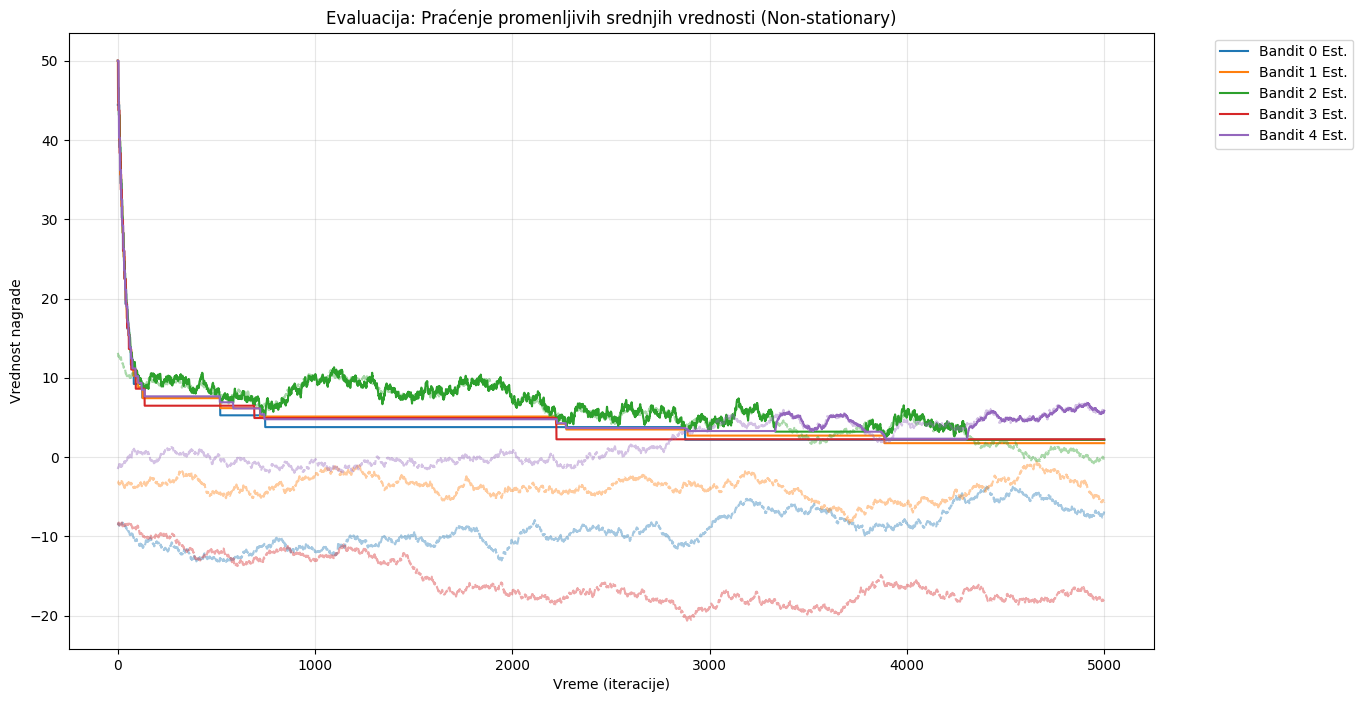

In [77]:
q_history = np.array(q_history)
true_means_history = np.array(true_means_history)

plt.figure(figsize=(14, 8))

# Crtamo samo za prvih nekoliko bandita da ne bude haos na grafiku (npr. 3)
# ili za sve ako ih je malo (ovde ih je 5, pa može sve)
for i in range(BANDITS_NO):
    color = plt.cm.tab10(i) # Dodeljujemo istu boju za par (procena, istina)

    # Puna linija = Procena (Q vrednost)
    plt.plot(q_history[:, i], color=color, label=f'Bandit {i} Est.')

    # Isprekidana linija = Stvarna vrednost (koja se sada menja)
    plt.plot(true_means_history[:, i], color=color, linestyle='--', alpha=0.4)

plt.title("Evaluacija: Praćenje promenljivih srednjih vrednosti (Non-stationary)")
plt.xlabel("Vreme (iteracije)")
plt.ylabel("Vrednost nagrade")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

**Komentar :** *Sada možemo jasnije da vidimo rezultat primene pohlepne politike sa nekim inicijalno pogođenim (zadatim) `q = 50` gde uočavamo smenu biranja 2 najbolja bandita (**Bandita 2** i **Bandita 4**) i vidimo da ukupna suma značajno bolje konvergira.*

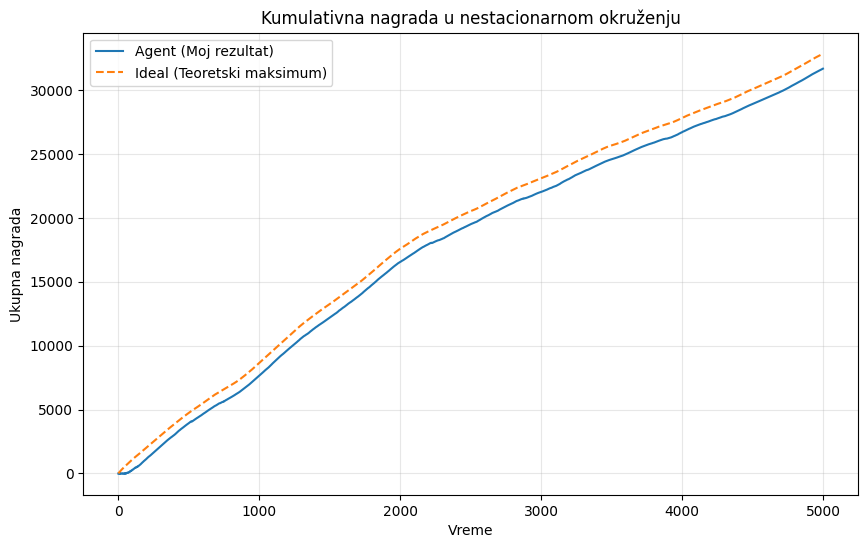

Ukupan Regret na kraju: 1169.55


In [78]:
# 1. Računamo šta je bio maksimum u svakom trenutku T
# true_means_history je matrica [vreme, banditi]
# axis=1 znači da za svaki vremenski korak tražimo najveću srednju vrednost među banditima
optimal_rewards_per_step = np.max(true_means_history, axis=1)

# 2. Pravimo kumulativnu sumu tih idealnih nagrada
ideal_cumulative = np.cumsum(optimal_rewards_per_step)

# 3. Tvoj stvarni rezultat
g = np.cumsum(rewards)

# 4. Crtanje
plt.figure(figsize=(10, 6))
plt.plot(g, label='Agent (Moj rezultat)')
plt.plot(ideal_cumulative, label='Ideal (Teoretski maksimum)', linestyle='--')

plt.title('Kumulativna nagrada u nestacionarnom okruženju')
plt.xlabel('Vreme')
plt.ylabel('Ukupna nagrada')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Dodatno: Izračunavanje 'Regret-a' (koliko smo izgubili u odnosu na ideal)
regret = ideal_cumulative - g
print(f"Ukupan Regret na kraju: {regret[-1]:.2f}")

In [79]:
EPSILON = 0
rewards = []
# Koristimo naučeno q
# Za potrebe crtanja i evaluacije moramo da pamtimo istoriju
q_history = []
true_means_history = []

# Parametar koliko se brzo menjaju banditi (standardna devijacija promene)
CHANGE_STD = 0.1

for t in trange(ATTEMPTS_NO):
    a = choose_eps_greedy_action(q, EPSILON)
    r = env.take_action(a)
    q[a] = q[a] + ALPHA * (r - q[a])

    # just for logging
    rewards.append(r)

    # Svakom banditu malo promenimo srednju vrednost (Random Walk)
    for b in env.bandits:
        b.mean += np.random.normal(0, CHANGE_STD)

    # Logovanje za grafik
    q_history.append(q.copy())
    # Pamtimo trenutne prave srednje vrednosti da vidimo da li ih stižemo
    true_means_history.append([b.mean for b in env.bandits])

100%|██████████| 5000/5000 [00:00<00:00, 119232.92it/s]


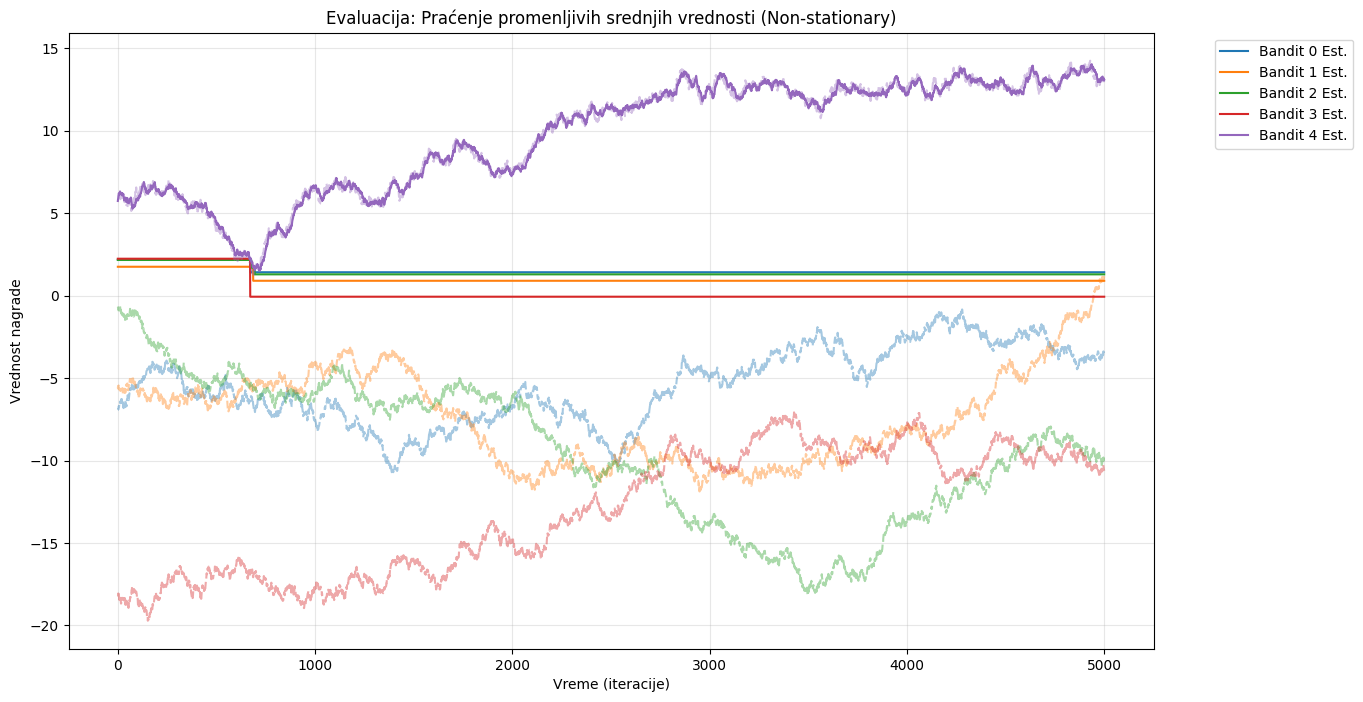

In [80]:
q_history = np.array(q_history)
true_means_history = np.array(true_means_history)

plt.figure(figsize=(14, 8))

# Crtamo samo za prvih nekoliko bandita da ne bude haos na grafiku (npr. 3)
# ili za sve ako ih je malo (ovde ih je 5, pa može sve)
for i in range(BANDITS_NO):
    color = plt.cm.tab10(i) # Dodeljujemo istu boju za par (procena, istina)

    # Puna linija = Procena (Q vrednost)
    plt.plot(q_history[:, i], color=color, label=f'Bandit {i} Est.')

    # Isprekidana linija = Stvarna vrednost (koja se sada menja)
    plt.plot(true_means_history[:, i], color=color, linestyle='--', alpha=0.4)

plt.title("Evaluacija: Praćenje promenljivih srednjih vrednosti (Non-stationary)")
plt.xlabel("Vreme (iteracije)")
plt.ylabel("Vrednost nagrade")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

**Komentar :** *Rezultat pohlepne politike koristeći naučeno `q` iz prethodnog slučaja. Uočavamo da najbolje poklapanje željene (idealne) i ostvarene vrednosti nagrade dobijamo baš koristeći ovu tehniku (faktor žaljenja je zanemarljivo mali, oko 0.05% za ovaj slučaj vremenski promenjivih bandita), nezavisno od toga da li su banditi vremenski promenjivi ili ne.*

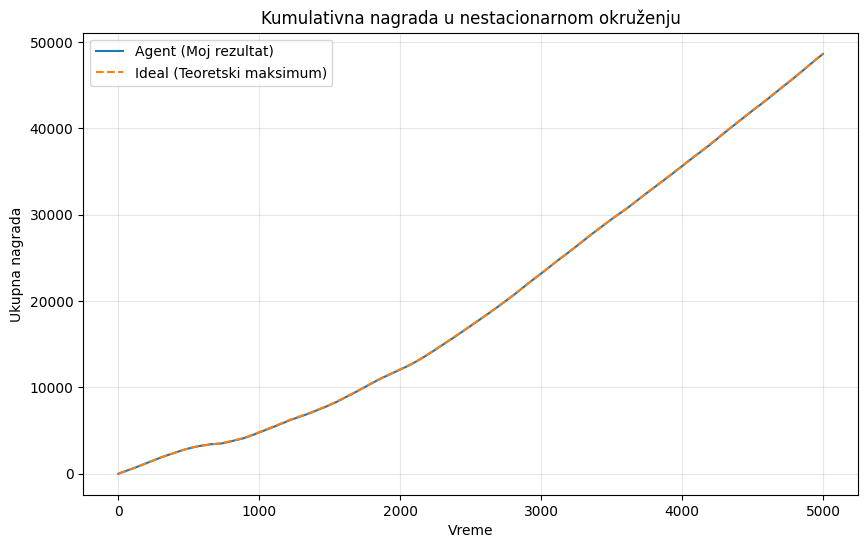

Ukupan Regret na kraju: 25.28


In [81]:
# 1. Računamo šta je bio maksimum u svakom trenutku T
# true_means_history je matrica [vreme, banditi]
# axis=1 znači da za svaki vremenski korak tražimo najveću srednju vrednost među banditima
optimal_rewards_per_step = np.max(true_means_history, axis=1)

# 2. Pravimo kumulativnu sumu tih idealnih nagrada
ideal_cumulative = np.cumsum(optimal_rewards_per_step)

# 3. Stvarni rezultat
g = np.cumsum(rewards)

# 4. Crtanje
plt.figure(figsize=(10, 6))
plt.plot(g, label='Agent (Moj rezultat)')
plt.plot(ideal_cumulative, label='Ideal (Teoretski maksimum)', linestyle='--')

plt.title('Kumulativna nagrada u nestacionarnom okruženju')
plt.xlabel('Vreme')
plt.ylabel('Ukupna nagrada')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Dodatno: Izračunavanje 'Regret-a' (koliko smo izgubili u odnosu na ideal)
regret = ideal_cumulative - g
print(f"Ukupan Regret na kraju: {regret[-1]:.2f}")

---

### Dodatni zadaci sa vežbi. Promena `broja iteracija` i promena faktora `p` odnosno `alpha` kod vremenski nepromenjivih i vremenski promenjivih bandita.

In [91]:
EPSILON = 0
ATTEMPTS_NO = 10000 # Promena broja iteracija sa 5000 na 10000


q = [100 for _ in range(BANDITS_NO)]
rewards = []
for t in trange(ATTEMPTS_NO):
    a = choose_eps_greedy_action(q, EPSILON)
    r = env.take_action(a)
    q[a] = q[a] + ALPHA * (r - q[a])

    # just for logging
    rewards.append(r)

100%|██████████| 10000/10000 [00:00<00:00, 340911.63it/s]


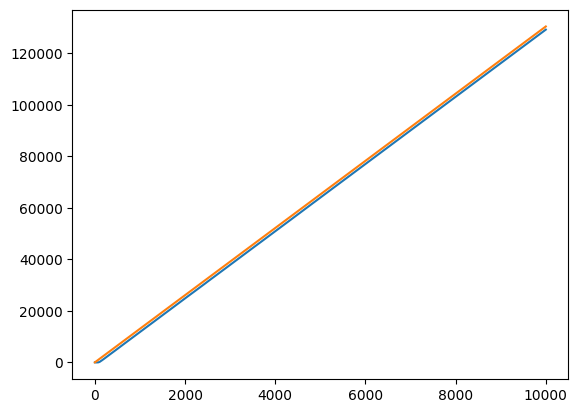

In [92]:
g = np.cumsum(rewards)
max_r = max([b.mean for b in env.bandits])
plt.plot(g)
plt.plot(np.cumsum(max_r * np.ones(len(g))))

**Komentar :** *Eksperimentalno je utvrđeno da i bez inicijalno naučenog `q`, koristeći pohlepnu politiku i posmatrajući dovoljno dug vremenski period možemo dobiti skoro idealno poklapanje željene i ostvarene vrednosti.*

In [117]:
EPSILON = 0
ATTEMPTS_NO = 5000
ALPHA = 0 # Promena vrednostisa 0.1 na 0

q = [100 for _ in range(BANDITS_NO)]
rewards = []
for t in trange(ATTEMPTS_NO):
    a = choose_eps_greedy_action(q, EPSILON)
    r = env.take_action(a)
    q[a] = q[a] + ALPHA * (r - q[a])

    # just for logging
    rewards.append(r)

100%|██████████| 5000/5000 [00:00<00:00, 298828.99it/s]


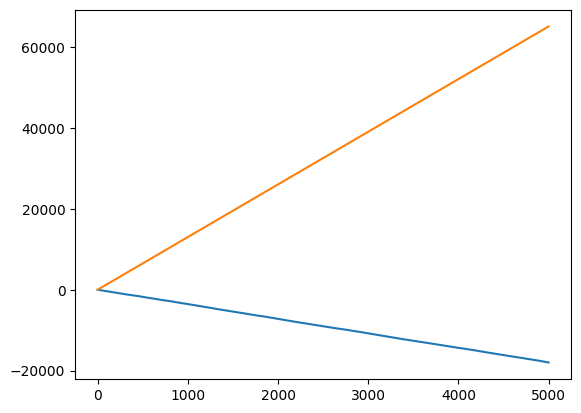

In [118]:
g = np.cumsum(rewards)
max_r = max([b.mean for b in env.bandits])
plt.plot(g)
plt.plot(np.cumsum(max_r * np.ones(len(g))))

**Komentar :** *Kao što vidimo, primenom pohlepne politike i zanemarivanjem vrednosti nagrade `alpha = 0` (`p = 1`) naša suma konstantno opada i vremenom se sve više udaljava od željene vrednosti (konstantno procenjujemo koju akciju biramo ali nikada je ne odigramo).*

In [175]:
EPSILON = 0
ATTEMPTS_NO = 5000
ALPHA = 0.2 # Promena vrednostisa 0 na 0.2

q = [100 for _ in range(BANDITS_NO)]
rewards = []
for t in trange(ATTEMPTS_NO):
    a = choose_eps_greedy_action(q, EPSILON)
    r = env.take_action(a)
    q[a] = q[a] + ALPHA * (r - q[a])

    # just for logging
    rewards.append(r)

100%|██████████| 5000/5000 [00:00<00:00, 300645.40it/s]


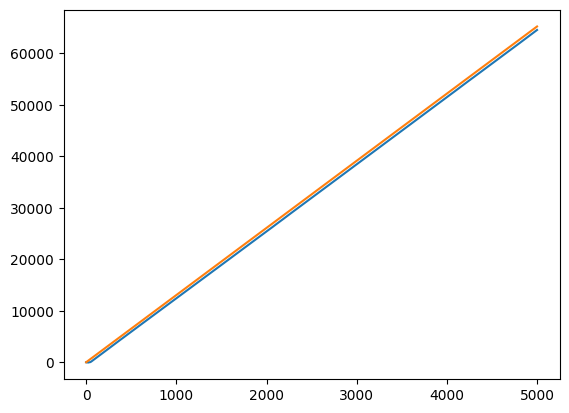

In [176]:
g = np.cumsum(rewards)
max_r = max([b.mean for b in env.bandits])
plt.plot(g)
plt.plot(np.cumsum(max_r * np.ones(len(g))))

**Komentar :** *Vidimo da koristeći pohlepnu politiku sa inicijalno zadatim (pogođenim `q = 100`) sa malom promenom `alpha`-e dobijamo poklapanje u velikoj meri i eksperimentalno je utvrđeno ali nije prikazano da se osetljivost povećavanjem `alpha` parametra sve više smanjuje i ostvarena vrednost u istoj meri idealno konvergira u željenu (npr. isti rezultat dobijamo za `alpha = 0.5` i `alpha = 1`). Takođe, eksperimentalno je utvrđeno ali nije prikazano da se za vrednosti `epsilon`-a veće od 0, menjanjem `alpha` parametra u opsegu 0-1 dešavaju zanemarljivo male promene, dok ako vrednost `alpha`-e krenemo povećavati preko 1 (npr. 2, 10, 20...) povećavamo faktor žaljenja tj. nagib između željene i ostvarene vrednosti. Drugim rečima primenom delimično nasumične politike, veću grešku dobijamo time što više "pažnje, prioriteta ili relevantnosti" pridajemo novim informacijama u odnosu na tekuću vrednost (pojačavamo šum).*

In [58]:
EPSILON = 0.1
ALPHA = 0.05 # Promena sa 0.1 na 0.05
BANDITS_NO = 5
ATTEMPTS_NO = 5000
q = [0 for _ in range(BANDITS_NO)] # Ponovo inicijalizacija
rewards = []

# Za potrebe crtanja i evaluacije moramo da pamtimo istoriju
q_history = []
true_means_history = []

# Parametar koliko se brzo menjaju banditi (standardna devijacija promene)
CHANGE_STD = 0.1

for t in trange(ATTEMPTS_NO):
    a = choose_eps_greedy_action(q, EPSILON)
    r = env.take_action(a)
    q[a] = q[a] + ALPHA * (r - q[a])

    # just for logging
    rewards.append(r)

    # Svakom banditu malo promenimo srednju vrednost (Random Walk)
    for b in env.bandits:
        b.mean += np.random.normal(0, CHANGE_STD)

    # Logovanje za grafik
    q_history.append(q.copy())
    # Pamtimo trenutne prave srednje vrednosti da vidimo da li ih stižemo
    true_means_history.append([b.mean for b in env.bandits])

100%|██████████| 5000/5000 [00:00<00:00, 56271.74it/s]


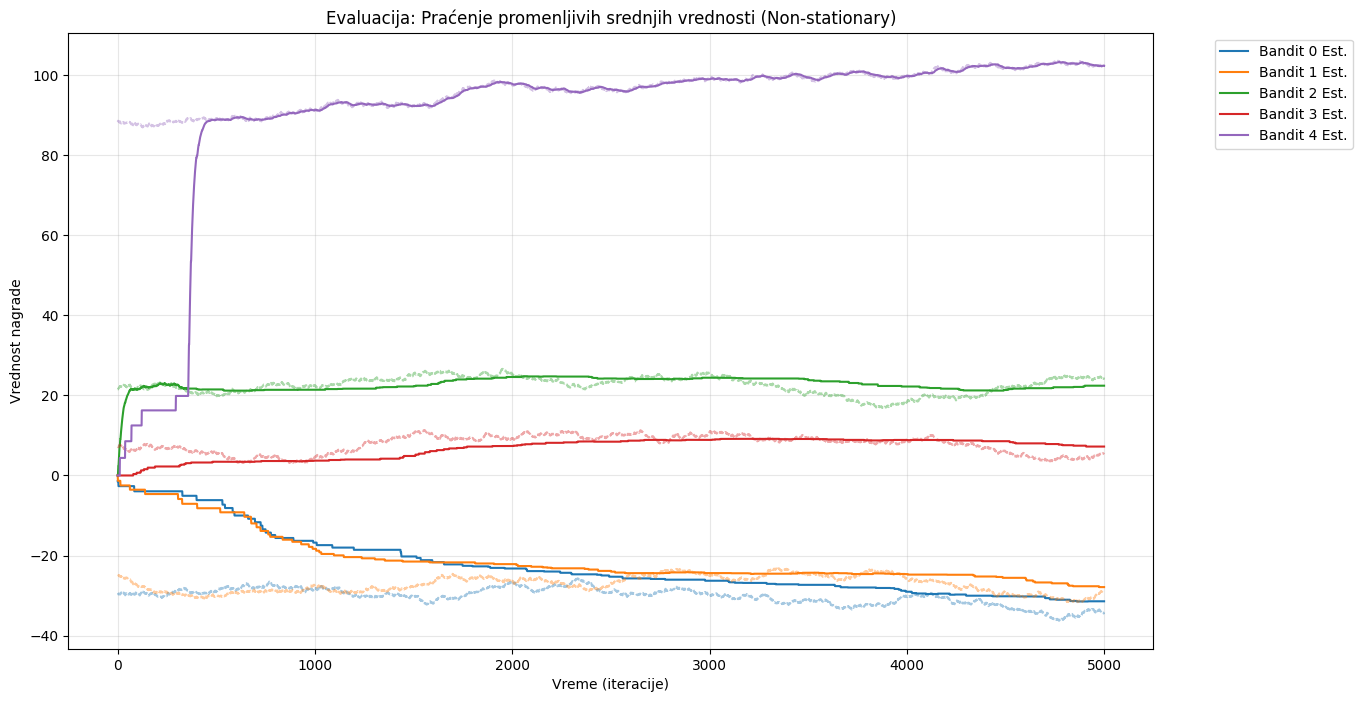

In [59]:
q_history = np.array(q_history)
true_means_history = np.array(true_means_history)

plt.figure(figsize=(14, 8))

# Crtamo samo za prvih nekoliko bandita da ne bude haos na grafiku (npr. 3)
# ili za sve ako ih je malo (ovde ih je 5, pa može sve)
for i in range(BANDITS_NO):
    color = plt.cm.tab10(i) # Dodeljujemo istu boju za par (procena, istina)

    # Puna linija = Procena (Q vrednost)
    plt.plot(q_history[:, i], color=color, label=f'Bandit {i} Est.')

    # Isprekidana linija = Stvarna vrednost (koja se sada menja)
    plt.plot(true_means_history[:, i], color=color, linestyle='--', alpha=0.4)

plt.title("Evaluacija: Praćenje promenljivih srednjih vrednosti (Non-stationary)")
plt.xlabel("Vreme (iteracije)")
plt.ylabel("Vrednost nagrade")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

**Komentar :** *Sa grafika možemo videti da se pri delimično nasumičnoj politici smanjenjem vrednosti `alpha` parametra ublažava vrednost devijacija ostvarenih vrednosti, odnosno da bolje konvergiraju u svoje željene vrednosti tokom vremena i da nema naglih skokova.*

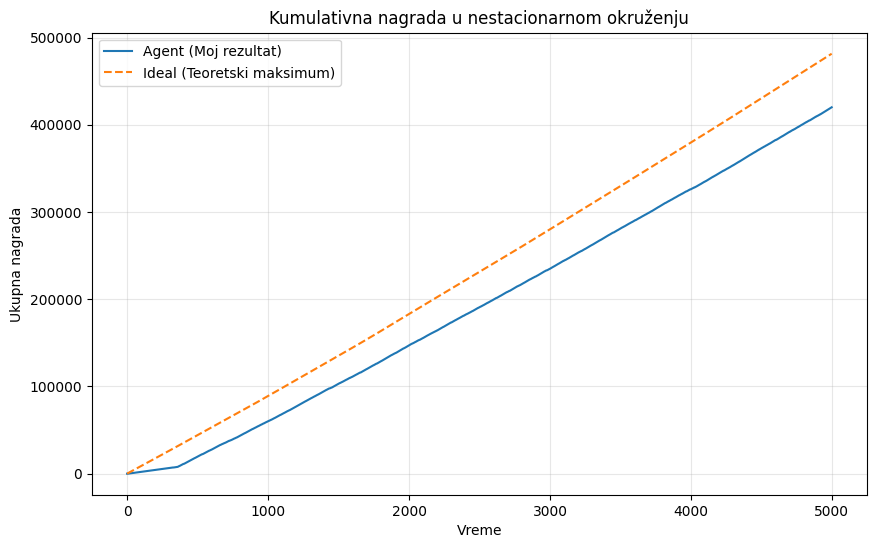

Ukupan Regret na kraju: 61423.50


In [60]:
# 1. Računamo šta je bio maksimum u svakom trenutku T
# true_means_history je matrica [vreme, banditi]
# axis=1 znači da za svaki vremenski korak tražimo najveću srednju vrednost među banditima
optimal_rewards_per_step = np.max(true_means_history, axis=1)

# 2. Pravimo kumulativnu sumu tih idealnih nagrada
ideal_cumulative = np.cumsum(optimal_rewards_per_step)

# 3. Stvarni rezultat
g = np.cumsum(rewards)

# 4. Crtanje
plt.figure(figsize=(10, 6))
plt.plot(g, label='Agent (Moj rezultat)')
plt.plot(ideal_cumulative, label='Ideal (Teoretski maksimum)', linestyle='--')

plt.title('Kumulativna nagrada u nestacionarnom okruženju')
plt.xlabel('Vreme')
plt.ylabel('Ukupna nagrada')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Dodatno: Izračunavanje 'Regret-a' (koliko smo izgubili u odnosu na ideal)
regret = ideal_cumulative - g
print(f"Ukupan Regret na kraju: {regret[-1]:.2f}")

In [61]:
EPSILON = 0.1
ALPHA = 0.1 # Promena sa 0.05 0.1
BANDITS_NO = 5
ATTEMPTS_NO = 5000
q = [0 for _ in range(BANDITS_NO)] # Ponovo inicijalizacija
rewards = []

# Za potrebe crtanja i evaluacije moramo da pamtimo istoriju
q_history = []
true_means_history = []

# Parametar koliko se brzo menjaju banditi (standardna devijacija promene)
CHANGE_STD = 0.1

for t in trange(ATTEMPTS_NO):
    a = choose_eps_greedy_action(q, EPSILON)
    r = env.take_action(a)
    q[a] = q[a] + ALPHA * (r - q[a])

    # just for logging
    rewards.append(r)

    # Svakom banditu malo promenimo srednju vrednost (Random Walk)
    for b in env.bandits:
        b.mean += np.random.normal(0, CHANGE_STD)

    # Logovanje za grafik
    q_history.append(q.copy())
    # Pamtimo trenutne prave srednje vrednosti da vidimo da li ih stižemo
    true_means_history.append([b.mean for b in env.bandits])

100%|██████████| 5000/5000 [00:00<00:00, 117298.91it/s]


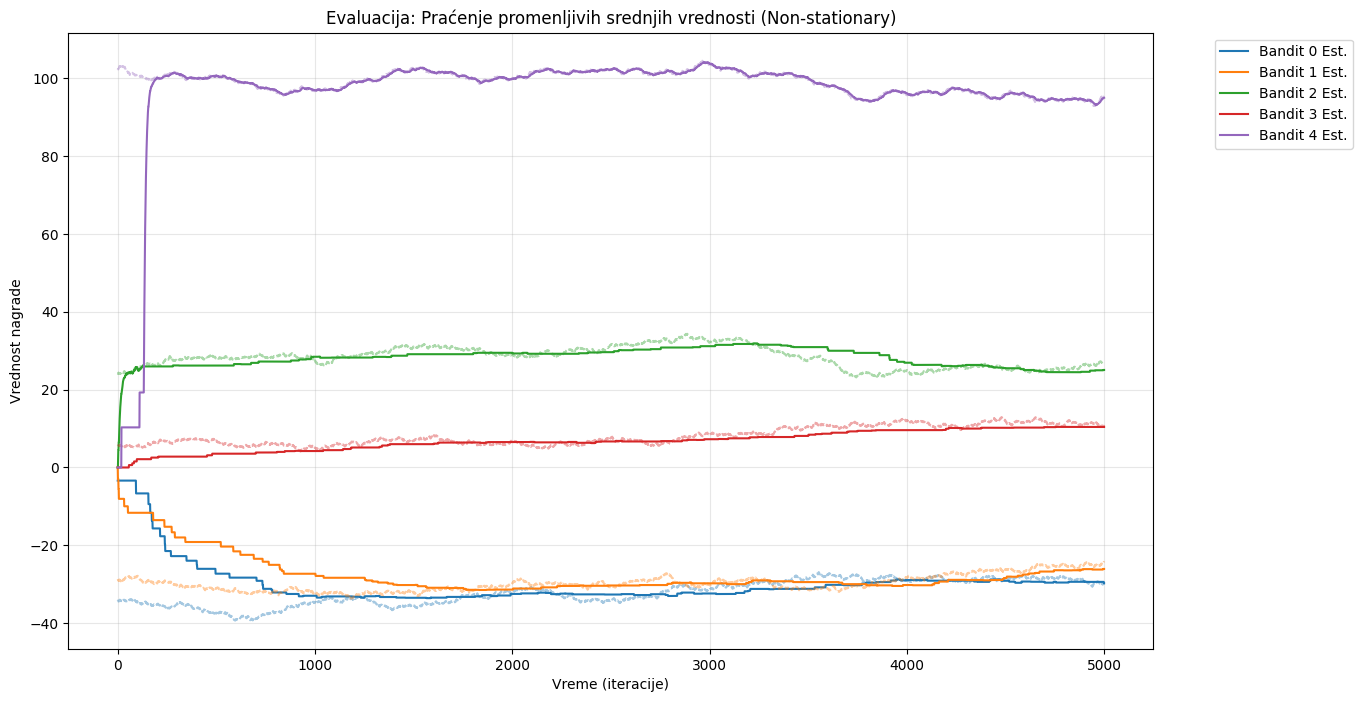

In [62]:
q_history = np.array(q_history)
true_means_history = np.array(true_means_history)

plt.figure(figsize=(14, 8))

# Crtamo samo za prvih nekoliko bandita da ne bude haos na grafiku (npr. 3)
# ili za sve ako ih je malo (ovde ih je 5, pa može sve)
for i in range(BANDITS_NO):
    color = plt.cm.tab10(i) # Dodeljujemo istu boju za par (procena, istina)

    # Puna linija = Procena (Q vrednost)
    plt.plot(q_history[:, i], color=color, label=f'Bandit {i} Est.')

    # Isprekidana linija = Stvarna vrednost (koja se sada menja)
    plt.plot(true_means_history[:, i], color=color, linestyle='--', alpha=0.4)

plt.title("Evaluacija: Praćenje promenljivih srednjih vrednosti (Non-stationary)")
plt.xlabel("Vreme (iteracije)")
plt.ylabel("Vrednost nagrade")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

**Komentar :** *Ovde je vrednost parametra `alpha` zadata difoltno, kao u početku, zarad lakšeg poređenja grafika.*

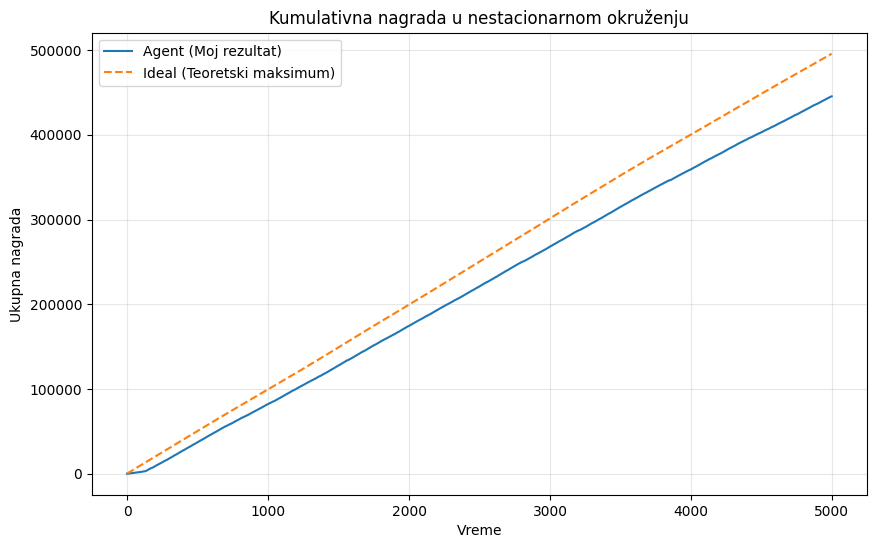

Ukupan Regret na kraju: 50308.86


In [63]:
# 1. Računamo šta je bio maksimum u svakom trenutku T
# true_means_history je matrica [vreme, banditi]
# axis=1 znači da za svaki vremenski korak tražimo najveću srednju vrednost među banditima
optimal_rewards_per_step = np.max(true_means_history, axis=1)

# 2. Pravimo kumulativnu sumu tih idealnih nagrada
ideal_cumulative = np.cumsum(optimal_rewards_per_step)

# 3. Stvarni rezultat
g = np.cumsum(rewards)

# 4. Crtanje
plt.figure(figsize=(10, 6))
plt.plot(g, label='Agent (Moj rezultat)')
plt.plot(ideal_cumulative, label='Ideal (Teoretski maksimum)', linestyle='--')

plt.title('Kumulativna nagrada u nestacionarnom okruženju')
plt.xlabel('Vreme')
plt.ylabel('Ukupna nagrada')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Dodatno: Izračunavanje 'Regret-a' (koliko smo izgubili u odnosu na ideal)
regret = ideal_cumulative - g
print(f"Ukupan Regret na kraju: {regret[-1]:.2f}")

In [64]:
EPSILON = 0.1
ALPHA = 0.8 # Promena sa 0.1 na 0.8
BANDITS_NO = 5
ATTEMPTS_NO = 5000
q = [0 for _ in range(BANDITS_NO)] # Ponovo inicijalizacija
rewards = []

# Za potrebe crtanja i evaluacije moramo da pamtimo istoriju
q_history = []
true_means_history = []

# Parametar koliko se brzo menjaju banditi (standardna devijacija promene)
CHANGE_STD = 0.1

for t in trange(ATTEMPTS_NO):
    a = choose_eps_greedy_action(q, EPSILON)
    r = env.take_action(a)
    q[a] = q[a] + ALPHA * (r - q[a])

    # just for logging
    rewards.append(r)

    # Svakom banditu malo promenimo srednju vrednost (Random Walk)
    for b in env.bandits:
        b.mean += np.random.normal(0, CHANGE_STD)

    # Logovanje za grafik
    q_history.append(q.copy())
    # Pamtimo trenutne prave srednje vrednosti da vidimo da li ih stižemo
    true_means_history.append([b.mean for b in env.bandits])

100%|██████████| 5000/5000 [00:00<00:00, 128765.49it/s]


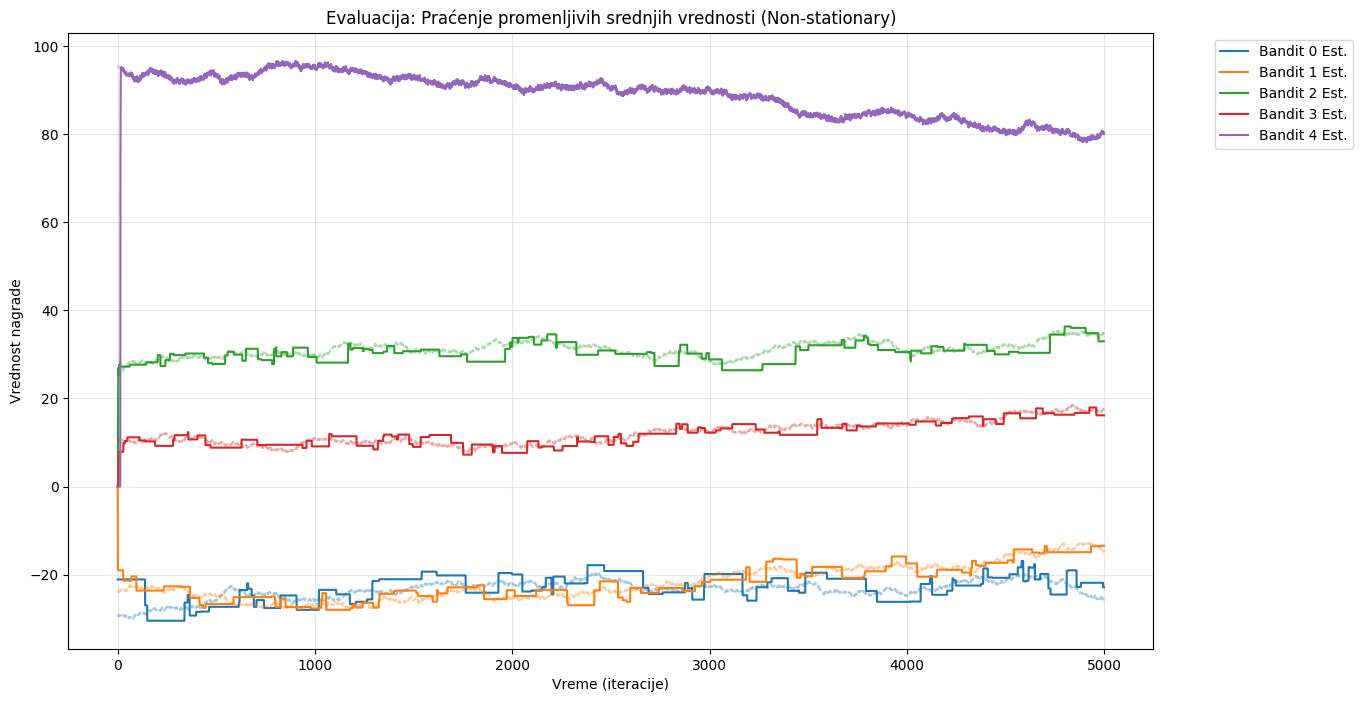

In [65]:
q_history = np.array(q_history)
true_means_history = np.array(true_means_history)

plt.figure(figsize=(14, 8))

# Crtamo samo za prvih nekoliko bandita da ne bude haos na grafiku (npr. 3)
# ili za sve ako ih je malo (ovde ih je 5, pa može sve)
for i in range(BANDITS_NO):
    color = plt.cm.tab10(i) # Dodeljujemo istu boju za par (procena, istina)

    # Puna linija = Procena (Q vrednost)
    plt.plot(q_history[:, i], color=color, label=f'Bandit {i} Est.')

    # Isprekidana linija = Stvarna vrednost (koja se sada menja)
    plt.plot(true_means_history[:, i], color=color, linestyle='--', alpha=0.4)

plt.title("Evaluacija: Praćenje promenljivih srednjih vrednosti (Non-stationary)")
plt.xlabel("Vreme (iteracije)")
plt.ylabel("Vrednost nagrade")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

**Komentar :** *Pretpostavka iz pretprošlog komentara se potvrđuje ovim eksperimentom. Veoma lako je uočljivo da se povećanjem vrednosti `alpha` parametra, pri čemu ostali parametri ostaju nepromenjeni, povećava odstupanje od srednje vrednosti, ali istovremeno se smanjuje faktor žaljenja.*

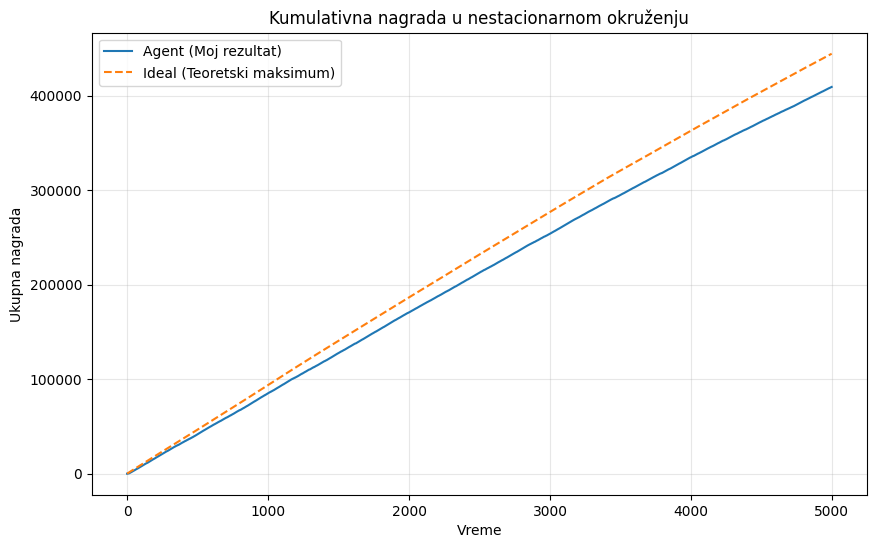

Ukupan Regret na kraju: 35152.44


In [66]:
# 1. Računamo šta je bio maksimum u svakom trenutku T
# true_means_history je matrica [vreme, banditi]
# axis=1 znači da za svaki vremenski korak tražimo najveću srednju vrednost među banditima
optimal_rewards_per_step = np.max(true_means_history, axis=1)

# 2. Pravimo kumulativnu sumu tih idealnih nagrada
ideal_cumulative = np.cumsum(optimal_rewards_per_step)

# 3. Stvarni rezultat
g = np.cumsum(rewards)

# 4. Crtanje
plt.figure(figsize=(10, 6))
plt.plot(g, label='Agent (Moj rezultat)')
plt.plot(ideal_cumulative, label='Ideal (Teoretski maksimum)', linestyle='--')

plt.title('Kumulativna nagrada u nestacionarnom okruženju')
plt.xlabel('Vreme')
plt.ylabel('Ukupna nagrada')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Dodatno: Izračunavanje 'Regret-a' (koliko smo izgubili u odnosu na ideal)
regret = ideal_cumulative - g
print(f"Ukupan Regret na kraju: {regret[-1]:.2f}")

In [67]:
EPSILON = 0
ALPHA = 0.8 # Ostaje 0.8 kao u prethodnom slučaju radi lakšeg poređenja
BANDITS_NO = 5
ATTEMPTS_NO = 5000
q = [0 for _ in range(BANDITS_NO)] # Ponovo inicijalizacija
rewards = []

# Za potrebe crtanja i evaluacije moramo da pamtimo istoriju
q_history = []
true_means_history = []

# Parametar koliko se brzo menjaju banditi (standardna devijacija promene)
CHANGE_STD = 0.1

for t in trange(ATTEMPTS_NO):
    a = choose_eps_greedy_action(q, EPSILON)
    r = env.take_action(a)
    q[a] = q[a] + ALPHA * (r - q[a])

    # just for logging
    rewards.append(r)

    # Svakom banditu malo promenimo srednju vrednost (Random Walk)
    for b in env.bandits:
        b.mean += np.random.normal(0, CHANGE_STD)

    # Logovanje za grafik
    q_history.append(q.copy())
    # Pamtimo trenutne prave srednje vrednosti da vidimo da li ih stižemo
    true_means_history.append([b.mean for b in env.bandits])

100%|██████████| 5000/5000 [00:00<00:00, 111784.91it/s]


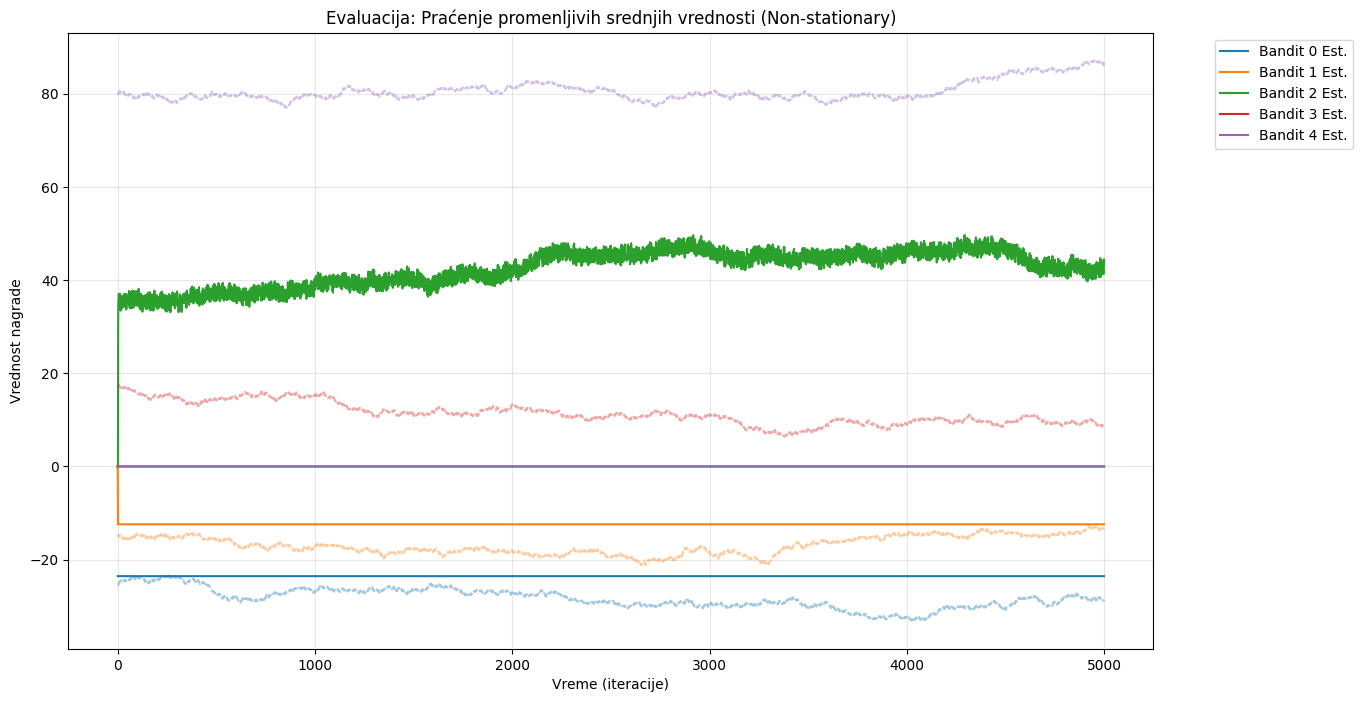

In [68]:
q_history = np.array(q_history)
true_means_history = np.array(true_means_history)

plt.figure(figsize=(14, 8))

# Crtamo samo za prvih nekoliko bandita da ne bude haos na grafiku (npr. 3)
# ili za sve ako ih je malo (ovde ih je 5, pa može sve)
for i in range(BANDITS_NO):
    color = plt.cm.tab10(i) # Dodeljujemo istu boju za par (procena, istina)

    # Puna linija = Procena (Q vrednost)
    plt.plot(q_history[:, i], color=color, label=f'Bandit {i} Est.')

    # Isprekidana linija = Stvarna vrednost (koja se sada menja)
    plt.plot(true_means_history[:, i], color=color, linestyle='--', alpha=0.4)

plt.title("Evaluacija: Praćenje promenljivih srednjih vrednosti (Non-stationary)")
plt.xlabel("Vreme (iteracije)")
plt.ylabel("Vrednost nagrade")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

**Komentar :** *U ovom slučaju vidimo da smo uprkos upotrebi pohlepne politike, izabrali Bandita koji nema najveću sredju vrednost, što je relativno čudno, mada je eksperimentalno utvrđeno i u slučaju ispod pokazano da u ovakvim situacijama početna suma `q` ima važnu ulogu i da se za različito inicijalno q dobijaju različita poklapanja.*

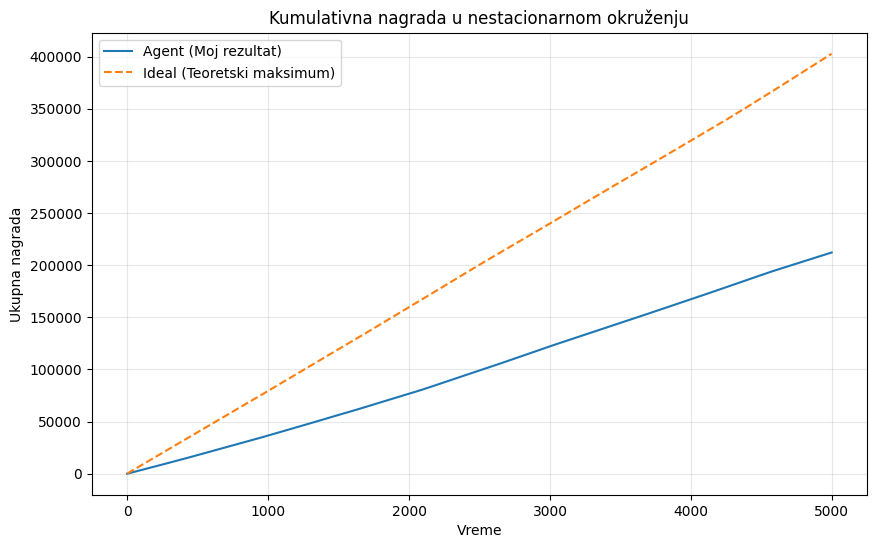

Ukupan Regret na kraju: 190676.89


In [69]:
# 1. Računamo šta je bio maksimum u svakom trenutku T
# true_means_history je matrica [vreme, banditi]
# axis=1 znači da za svaki vremenski korak tražimo najveću srednju vrednost među banditima
optimal_rewards_per_step = np.max(true_means_history, axis=1)

# 2. Pravimo kumulativnu sumu tih idealnih nagrada
ideal_cumulative = np.cumsum(optimal_rewards_per_step)

# 3. Stvarni rezultat
g = np.cumsum(rewards)

# 4. Crtanje
plt.figure(figsize=(10, 6))
plt.plot(g, label='Agent (Moj rezultat)')
plt.plot(ideal_cumulative, label='Ideal (Teoretski maksimum)', linestyle='--')

plt.title('Kumulativna nagrada u nestacionarnom okruženju')
plt.xlabel('Vreme')
plt.ylabel('Ukupna nagrada')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Dodatno: Izračunavanje 'Regret-a' (koliko smo izgubili u odnosu na ideal)
regret = ideal_cumulative - g
print(f"Ukupan Regret na kraju: {regret[-1]:.2f}")

In [70]:
EPSILON = 0
ALPHA = 0.8 # Ostaje 0.8 kao u prethodnom slučaju radi lakšeg poređenja
BANDITS_NO = 5
ATTEMPTS_NO = 5000
q = [100 for _ in range(BANDITS_NO)] # Ponovo inicijalizacija
rewards = []

# Za potrebe crtanja i evaluacije moramo da pamtimo istoriju
q_history = []
true_means_history = []

# Parametar koliko se brzo menjaju banditi (standardna devijacija promene)
CHANGE_STD = 0.1

for t in trange(ATTEMPTS_NO):
    a = choose_eps_greedy_action(q, EPSILON)
    r = env.take_action(a)
    q[a] = q[a] + ALPHA * (r - q[a])

    # just for logging
    rewards.append(r)

    # Svakom banditu malo promenimo srednju vrednost (Random Walk)
    for b in env.bandits:
        b.mean += np.random.normal(0, CHANGE_STD)

    # Logovanje za grafik
    q_history.append(q.copy())
    # Pamtimo trenutne prave srednje vrednosti da vidimo da li ih stižemo
    true_means_history.append([b.mean for b in env.bandits])

100%|██████████| 5000/5000 [00:00<00:00, 111377.65it/s]


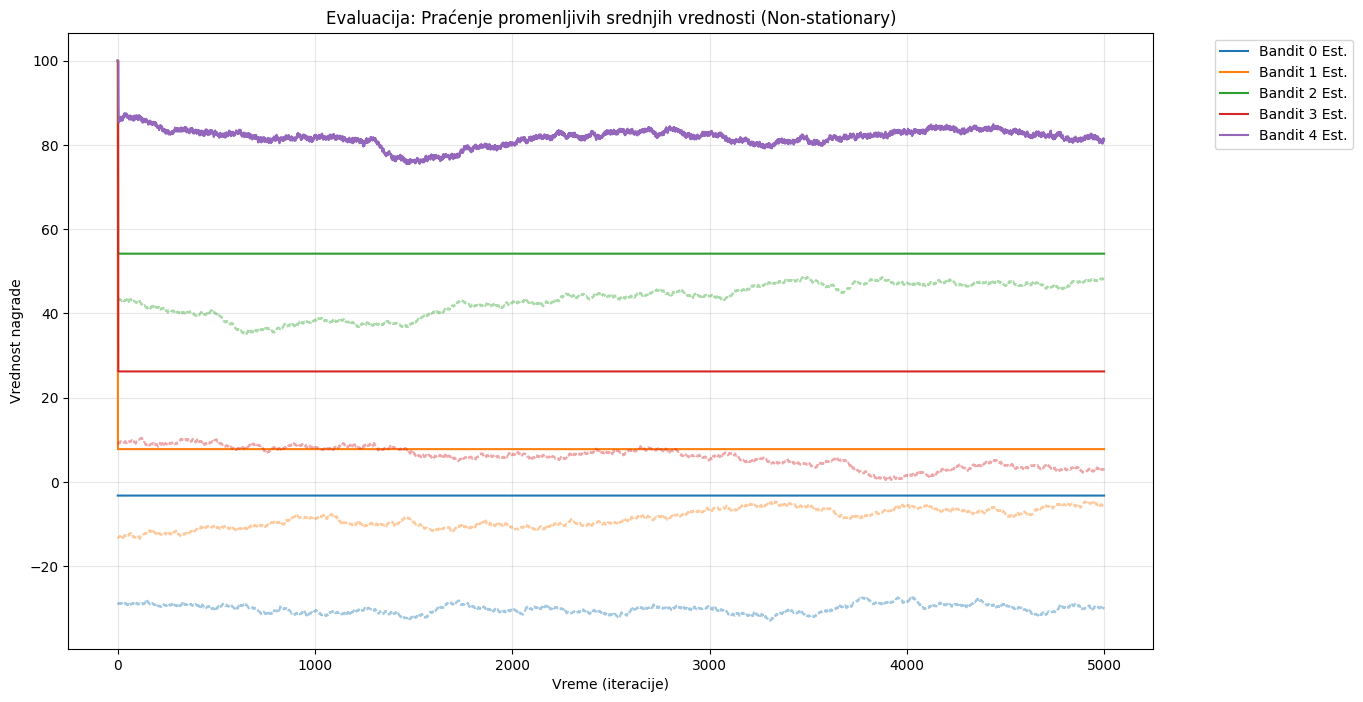

In [71]:
q_history = np.array(q_history)
true_means_history = np.array(true_means_history)

plt.figure(figsize=(14, 8))

# Crtamo samo za prvih nekoliko bandita da ne bude haos na grafiku (npr. 3)
# ili za sve ako ih je malo (ovde ih je 5, pa može sve)
for i in range(BANDITS_NO):
    color = plt.cm.tab10(i) # Dodeljujemo istu boju za par (procena, istina)

    # Puna linija = Procena (Q vrednost)
    plt.plot(q_history[:, i], color=color, label=f'Bandit {i} Est.')

    # Isprekidana linija = Stvarna vrednost (koja se sada menja)
    plt.plot(true_means_history[:, i], color=color, linestyle='--', alpha=0.4)

plt.title("Evaluacija: Praćenje promenljivih srednjih vrednosti (Non-stationary)")
plt.xlabel("Vreme (iteracije)")
plt.ylabel("Vrednost nagrade")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

**Komentar :** *Kao što je u komentaru iznad spomenuto, ovo je idealan primer kako za inicijalno dobro postavljenu vrednost `q`, za razliku od prošlog slučaja i istu vrednost parametra `alpha` kao u prošlom slučaju možemo imati idealno poklapanje željene i ostvarene vrednosti.*

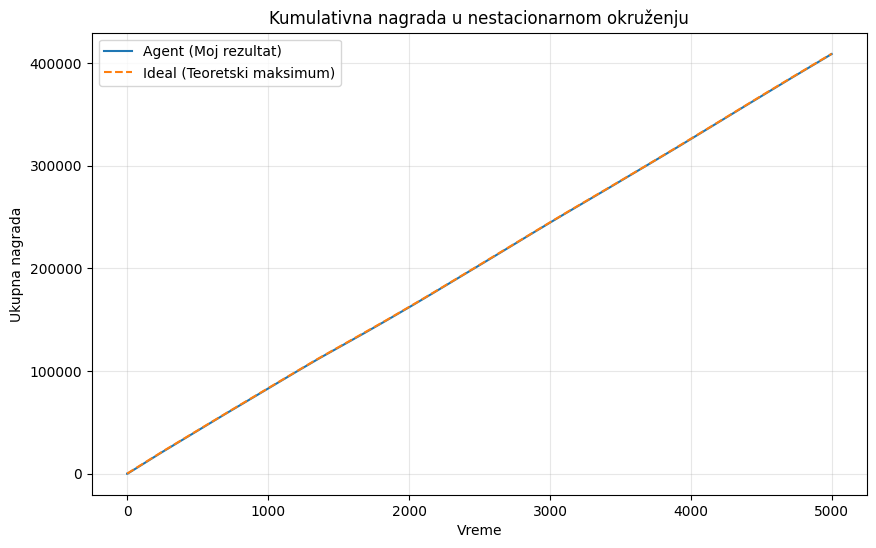

Ukupan Regret na kraju: 295.87


In [72]:
 # 1. Računamo šta je bio maksimum u svakom trenutku T
# true_means_history je matrica [vreme, banditi]
# axis=1 znači da za svaki vremenski korak tražimo najveću srednju vrednost među banditima
optimal_rewards_per_step = np.max(true_means_history, axis=1)

# 2. Pravimo kumulativnu sumu tih idealnih nagrada
ideal_cumulative = np.cumsum(optimal_rewards_per_step)

# 3. Stvarni rezultat
g = np.cumsum(rewards)

# 4. Crtanje
plt.figure(figsize=(10, 6))
plt.plot(g, label='Agent (Moj rezultat)')
plt.plot(ideal_cumulative, label='Ideal (Teoretski maksimum)', linestyle='--')

plt.title('Kumulativna nagrada u nestacionarnom okruženju')
plt.xlabel('Vreme')
plt.ylabel('Ukupna nagrada')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Dodatno: Izračunavanje 'Regret-a' (koliko smo izgubili u odnosu na ideal)
regret = ideal_cumulative - g
print(f"Ukupan Regret na kraju: {regret[-1]:.2f}")